## Introduction

During the hyperparameter optimization, we constrained the scope size (max: 30) and the number of batches (max: 10) to keep the final settings experimentally tractable. We also carried out a similar hyperparameter optimization without these constraints to compare the settings selected under the restrictions outlined above to the best possible settings. To keep the optimization computationally tractable, we used a maximum scope size of 60 samples, but did not implement a restriction for the number of batches. Because of that, we also allowed the batch size 1.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from Code.benchmark import Benchmark
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
import warnings
from pathlib import Path
import os
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorsys

# Doyle colors
doyle_colors = ["#CE4C6F", "#1561C2", "#188F9D","#C4ADA2","#515798", "#CB7D85", "#A9A9A9"]
# extension of palette with lighter and darker versions
def adjust_lightness(color, factor=1.2):
    """
    Function to make colors lighter (factor > 1) or darker (factor < 1).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

lighter = [adjust_lightness(c, 1.2) for c in doyle_colors]
darker  = [adjust_lightness(c, 0.7) for c in doyle_colors]
all_colors = doyle_colors + darker[::-1] + lighter[::-1] 

# Save the categorical colormap
cat_cmap = ListedColormap(all_colors, name="Doyle_cat")
plt.colormaps.register(cat_cmap)

# Define and save a continuous colormap
colors = [doyle_colors[1],"#FFFFFFD1",doyle_colors[0]]
cont_cmap = LinearSegmentedColormap.from_list("Doyle_cont", colors)
plt.colormaps.register(cont_cmap)

wdir = Path(".")

# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14, # Legend titles
    "font.family": "Helvetica"   # Font
    })

Get the standardization metrics

In [ ]:
# define a running variable with the datasets
datasets = ["high","medium","low"]
# define a variable with the acquisition functions
acqfct = ["balanced","greedy"]
# define some Vendi pruning options for the different batch sizes 
# (in addition to the ones run with the constrained scopes)
# (options were only selected if they would not exhaust any search space of the datasets)
# max sample sizes for batch pruning and different batch sizes and Vendi pruning
combs_bprune = {
    1: {0: 60, 5: 60, 10: 36, 15: 26, 20: 21},
    2: {0: 60, 5: 60, 10: 60, 15: 47, 20: 37},
    3: {0: 60, 5: 60, 10: 60, 15: 60, 20: 51, 25: 42, 30: 36, 35: 31},
    4: {0: 60, 5: 60, 10: 60, 15: 60, 20: 60, 25: 53, 30: 46, 35: 40, 40: 35, 45: 31}
    }
# max sample sizes for sample pruning and different batch sizes and Vendi pruning
combs_sprune = {
    1: {0: 60, 3: 60, 6: 53, 9: 39, 12: 31},
    2: {0: 60, 3: 60, 6: 54, 9: 40, 12: 32},
    3: {0: 60, 3: 60, 6: 55, 9: 41, 12: 33},
    4: {0: 60, 3: 60, 6: 56, 9: 42, 12: 34}
    }

## Condition screening

In [3]:
# # run different settings with batch pruning (pruning before every round of experiments)
# for dset in datasets:
#     for acq in acqfct:
#         for batch in combs_bprune.keys():
#             pruning_dict = combs_bprune[batch]
#             for pruning in pruning_dict.keys():
#                 Benchmark().collect_data(
#                     filename_labelled = f"./../0_Data/Datasets/Datasets_Hyperpar_Opt/data-{dset}.csv",  
#                     name_results = f"./Results_Data/Unconstrained_Scope/Cond_Screen/{acq}_{dset}/{pruning_dict[pruning]}{acq}_b{batch}_V{pruning}",  
#                     objectives=['rate'],  
#                     budget = pruning_dict[pruning],
#                     batches= [batch],
#                     Vendi_pruning_fractions = [pruning],
#                     seeds = 20,
#                     acquisition_function_mode= acq,
#                     pruning_metric= "vendi_batch",
#                     init_sampling_method="random"
#                     )

In [4]:
# # run different settings with sample pruning (pruning before every round of experiments)
# for dset in datasets:
#     for acq in acqfct:
#         for batch in combs_sprune.keys():
#             pruning_dict = combs_sprune[batch]
#             for pruning in pruning_dict.keys():
#                 Benchmark().collect_data(
#                     filename_labelled = f"./../0_Data/Datasets/Datasets_Hyperpar_Opt/data-{dset}.csv",  
#                     name_results = f"./Results_Data/Unconstrained_Scope/screen_sprune/{acq}_{dset}/{pruning_dict[pruning]}{acq}_b{batch}_V{pruning}",  
#                     objectives=['rate'],  
#                     budget = pruning_dict[pruning],
#                     batches= [batch],
#                     Vendi_pruning_fractions = [pruning],
#                     seeds = 20,
#                     acquisition_function_mode= acq,
#                     pruning_metric= "vendi_sample",
#                     init_sampling_method="random"
#                     )

In [5]:
# load the normalization bounds
df_bounds = pd.read_csv(f"./../0_Data/Datasets/Datasets_Hyperpar_Opt/bounds.csv",index_col=0)
df_bounds

,high,medium,low
obj_min,0.432225,1.174966,2.154690
obj_max,0.603510,1.984558,2.483439
vendi_min,2.392147,2.166708,2.043167
vendi_max,6.505295,6.313570,5.846067


In [6]:
# define a function to extract the relevant bounds in a format suitable for the Benchmark class
def get_bounds(dset):
    bounds = {}
    # get the metrics for the rate objective
    bounds["rate"] = (df_bounds.loc["obj_max",dset],df_bounds.loc["obj_min",dset])
    # get the metrics for the vendi score
    bounds["vendi"] = (df_bounds.loc["vendi_max",dset],df_bounds.loc["vendi_min",dset])

    return bounds

In [ ]:
# combine the results for the unconstrained scope runs for each dataset
dfs_unconstrained = {}
for dset in datasets:
    dfs = {}
    for pruning_mode in ["sprune","bprune"]:
        if pruning_mode == "sprune":
            combs = combs_sprune
        else:
            combs = combs_bprune
        for acq in acqfct:
            for batch in combs.keys():
                pruning_dict = combs[batch]
                for pruning in pruning_dict.keys():
                    dfs_progress = Benchmark().progress_plot(budget=pruning_dict[pruning],type_results="scope",
                                        name_results=f"./Results_Data/Unconstrained_Scope"\
                                            f"/screen_{pruning_mode}/{acq}_{dset}"\
                                                f"/{pruning_dict[pruning]}{acq}_b{batch}_V{pruning}",
                                        bounds=get_bounds(dset),show_plot = False)
                    dfs[f"{pruning_mode}_{acq}_b{batch}_V{pruning}"] = dfs_progress["means"]
    # combine
    dfs_unconstrained[dset] = pd.concat(dfs,axis=1)
    # clean up the column names (currently multi index)
    dfs_unconstrained[dset].columns = [midx[0] for midx in dfs_unconstrained[dset].columns] 
    dfs_unconstrained[dset].columns = [re.sub(r'V(\d)(?!\d)', r'V0\1', col) for col in dfs_unconstrained[dset].columns]

    # sort the columns
    dfs_unconstrained[dset] = dfs_unconstrained[dset][sorted(dfs_unconstrained[dset].columns)]

In [8]:
# combine the results of the constrained scope runs for each dataset (run in another Jupyter notebook)
dfs_screening = {}
for dset in datasets:
    dfs = {}
    for prune in ["sprune","bprune"]:
        # read in the data
        for acq in acqfct:
            for batch in [2,3,4]:
                if prune == "sprune":
                    # sample pruning data from the constrained scope runs
                    dfs_progress = Benchmark().progress_plot(budget=30,type_results="scope",
                                                            name_results=f"./Results_Data/Cond_Screen"\
                                                                f"/screen_{prune}/30{acq}_{dset}",
                                                            bounds=get_bounds(dset), show_plot = False)
                    dfs[f"{prune}_{acq}"] = dfs_progress["means"]
                elif prune == "bprune":
                    # batch pruning data from the constrained scope runs
                    dfs_progress = Benchmark().progress_plot(budget=30,type_results="scope",
                                                            name_results=f"./Results_Data/Cond_Screen"\
                                                                f"/screen_{prune}/30{acq}_{dset}/30{acq}_b{batch}",
                                                            bounds=get_bounds(dset), show_plot = False)
                    dfs[f"{prune}_{acq}_b{batch}"] = dfs_progress["means"]
    # combine
    dfs_screening[dset] = pd.concat(dfs,axis=1)
    # clean up the column names (currently multi index)
    dfs_screening[dset].columns = [midx[0]+"_"+midx[1] for midx in dfs_screening[dset].columns] 
    dfs_screening[dset].columns = [re.sub(r'(b\d+)_b\d+', r'\1', col) 
                                   if "bprune" in col else col for col in dfs_screening[dset].columns] 
    dfs_screening[dset].columns = [re.sub(r'V(\d)(?!\d)', r'V0\1', col) for col in dfs_screening[dset].columns]

    # sort the columns
    dfs_screening[dset] = dfs_screening[dset][sorted(dfs_screening[dset].columns)]

In [ ]:
# extract the data from the finetuning runs (run in another Jupyter notebook)
dfs_results_ftuning = {}
for dset in datasets:
    dfs = {}
    for prune in ["sprune","bprune"]:
        # read in the data
        for acq in acqfct:
            for batch in [3,4]:
                if prune == "sprune":
                    if acq == "balanced":
                        dfs_progress = Benchmark().progress_plot(budget=30,type_results="scope",
                                                                name_results=f"./Results_Data/Cond_Screen"\
                                                                    f"/screen_{prune}/tuning/30{acq}_{dset}"\
                                                                        f"/30{acq}_b{batch}",
                                                                bounds=get_bounds(dset),show_plot = False)
                        dfs[f"{prune}_{acq}"] = dfs_progress["means"]
                elif prune == "bprune":
                    if acq == "balanced":
                        dfs_progress = Benchmark().progress_plot(budget=30,type_results="scope",
                                                                name_results=f"./Results_Data/Cond_Screen"\
                                                                    f"/screen_{prune}/tuning/30{acq}_{dset}"\
                                                                        f"/30{acq}_b{batch}",
                                                                bounds=get_bounds(dset),show_plot = False)
                        dfs[f"{prune}_{acq}_b{batch}"] = dfs_progress["means"]
    # combine
    dfs_results_ftuning[dset] = pd.concat(dfs,axis=1)
    # clean up the column names (currently multi index)
    dfs_results_ftuning[dset].columns = [midx[0]+"_"+midx[1] for midx in dfs_results_ftuning[dset].columns] 
    dfs_results_ftuning[dset].columns = [re.sub(r'(b\d+)_b\d+', r'\1', col) 
                                         if "bprune" in col else col 
                                         for col in dfs_results_ftuning[dset].columns] 
    dfs_results_ftuning[dset].columns = [re.sub(r'V(\d)(?!\d)', r'V0\1', col) for col in dfs_results_ftuning[dset].columns]

    # sort the columns
    dfs_results_ftuning[dset] = dfs_results_ftuning[dset][sorted(dfs_results_ftuning[dset].columns)]

In [10]:
# combine with the already existing results
dfs_results = {}
for dset in datasets:
    # combine
    dfs_results[dset] = pd.concat([dfs_unconstrained[dset],dfs_screening[dset],dfs_results_ftuning[dset]],axis=1)
    
    # some settings were run both with unconstrained and constrained scopes. 
    # keep the first one (unconstrained) because larger scope sizes were allowed
    dfs_results[dset] = dfs_results[dset].loc[:, ~dfs_results[dset].columns.duplicated(keep="first")]

    # sort the columns
    dfs_results[dset] = dfs_results[dset][sorted(set(dfs_results[dset].columns))]   


There are 159 different scopes with 20 random seeds each for every dataset.
The shown results are averaged across the random seeds.


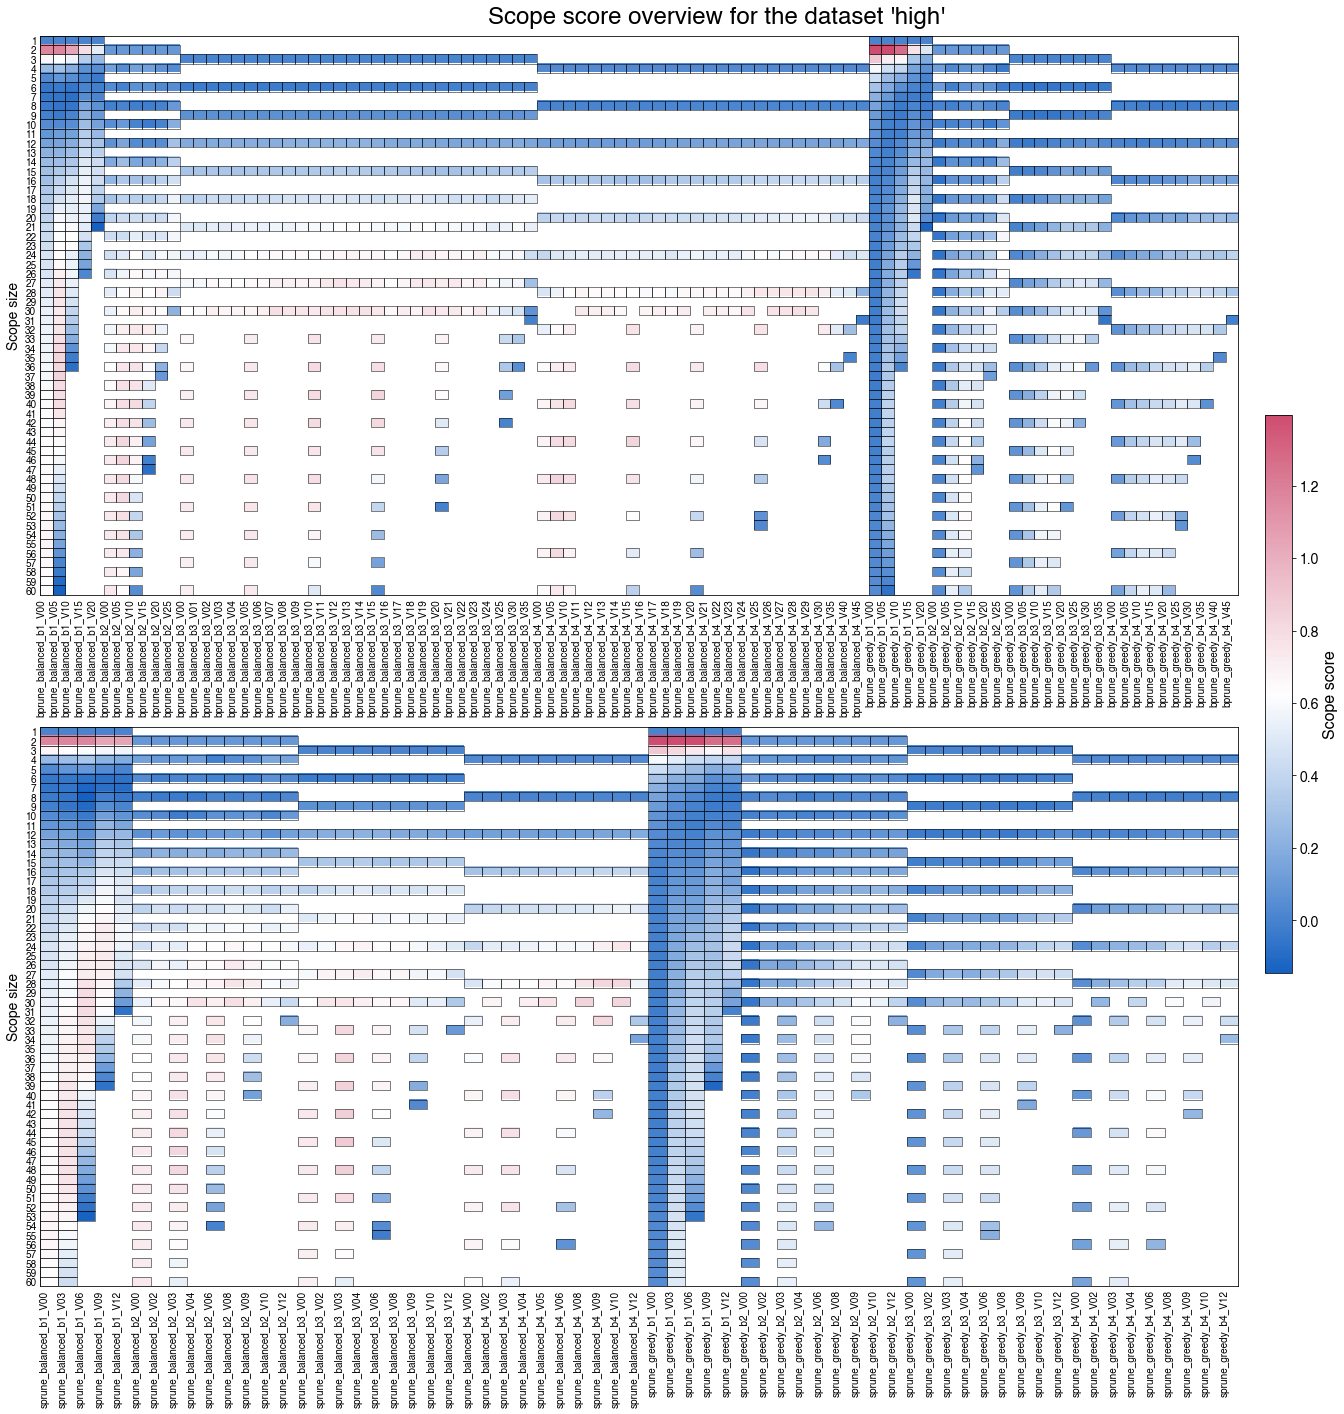

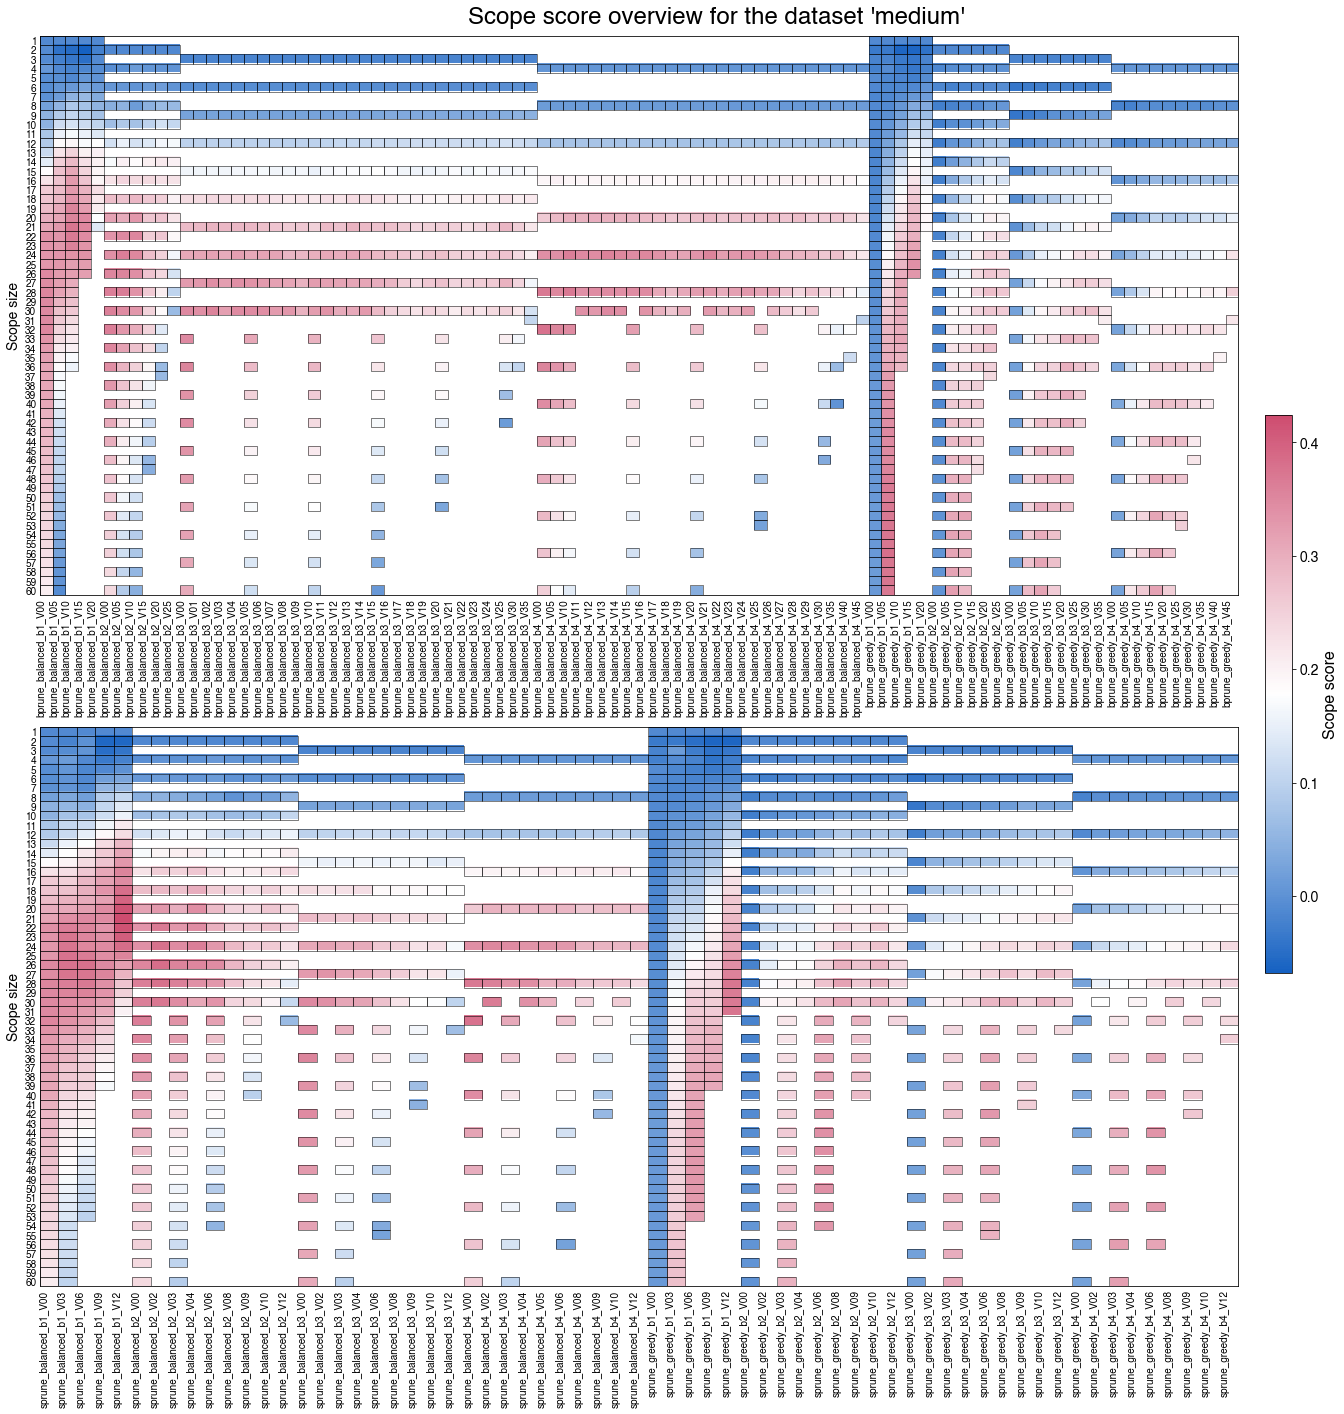

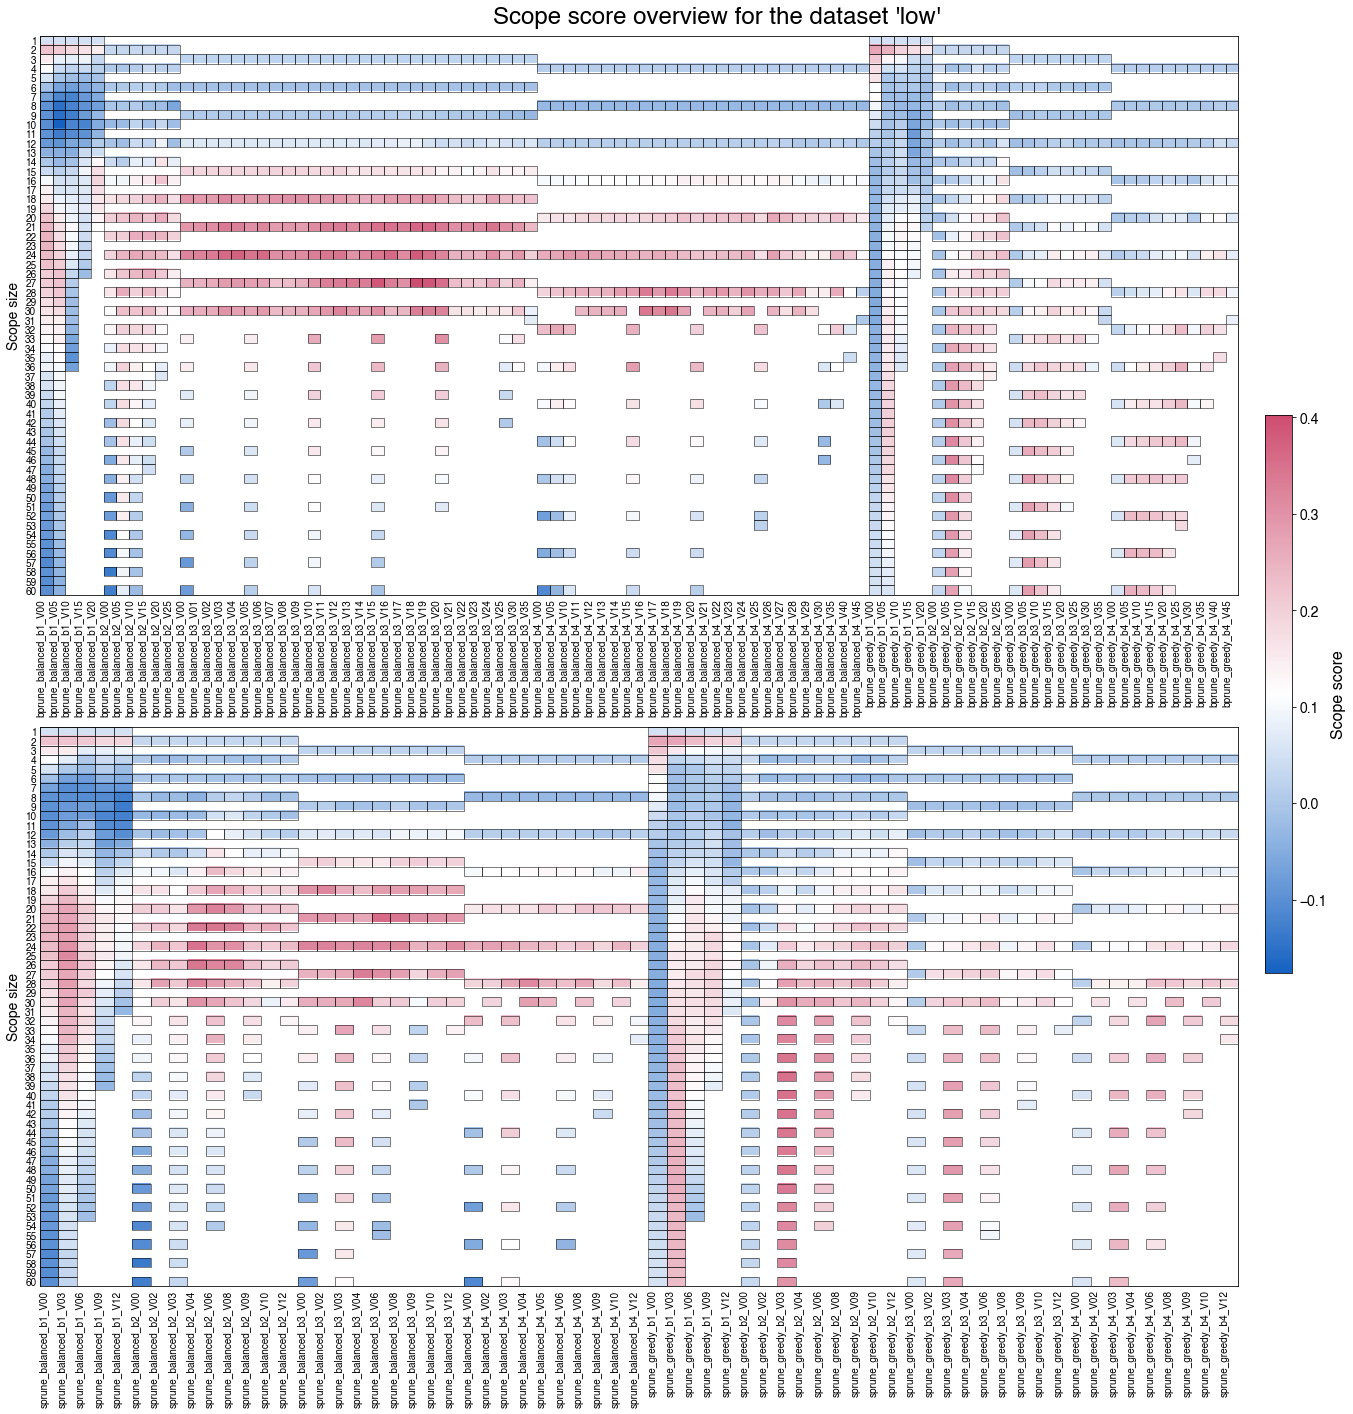

In [11]:
def get_overview_plot():
    warnings.filterwarnings("ignore", message=".*tight_layout.*")

    print(f"There are {len(dfs_results['high'].columns)} different scopes with "
          "20 random seeds each for every dataset.\nThe shown results are averaged across the random seeds.")

    for dset in datasets:
        fig, axes = plt.subplots(2, 1, figsize=(20, 20))
        fig.suptitle(f"Scope score overview for the dataset '{dset}'")

        # Select bprune and sprune data
        bprune_col = [col for col in dfs_results[dset].columns if "bprune" in col]
        sprune_col = [col for col in dfs_results[dset].columns if "sprune" in col]
        bprune_data = dfs_results[dset][bprune_col]
        sprune_data = dfs_results[dset][sprune_col]

        # Shared color scale
        min_val = dfs_results[dset].min().min()
        max_val = dfs_results[dset].max().max()

        # Define colormap with white for NaN
        cmap = plt.cm.get_cmap("Doyle_cont").copy()
        cmap.set_bad(color="white")

        # Helper to draw one heatmap
        def draw_heatmap(ax, data):
            arr = data.to_numpy()
            masked = np.ma.masked_invalid(arr)
            im = ax.imshow(masked, cmap=cmap, vmin=min_val, vmax=max_val, aspect="auto")

            # Draw grid lines only around non-NaN cells
            nrows, ncols = arr.shape
            for i in range(nrows):
                for j in range(ncols):
                    if not np.isnan(arr[i, j]):
                        ax.add_patch(plt.Rectangle(
                            (j - 0.5, i - 0.5), 1, 1,
                            fill=False, edgecolor="k", lw=0.5
                        ))

            # Axes labels & ticks
            ax.set_xticks(np.arange(ncols))
            ax.set_yticks(np.arange(nrows))
            ax.set_xticklabels(data.columns, rotation=90, ha='right', fontsize=10)
            ax.set_yticklabels(data.index, fontsize=10)
            ax.tick_params(length=0)

            return im

        # Plot both heatmaps
        im0 = draw_heatmap(axes[0], bprune_data)
        im1 = draw_heatmap(axes[1], sprune_data)

        # Colorbar shared
        cbar = fig.colorbar(im0, ax=axes, location="right",
                            fraction=0.025, pad=0.02, label="Scope score")

        # Axis labels
        axes[0].set_ylabel("Scope size", fontsize=14)
        axes[1].set_ylabel("Scope size", fontsize=14)

        plt.tight_layout(rect=[0, 0, 0.87, 0.99])
        plt.show()

get_overview_plot()

Get the best scope score for each dataset

Best scope score for the dataset 'high': 1.4 (size2_bprune_greedy_b1_V00)
Best scope score for the dataset 'medium': 0.42 (size21_sprune_balanced_b1_V12)
Best scope score for the dataset 'low': 0.4 (size27_bprune_balanced_b3_V18)


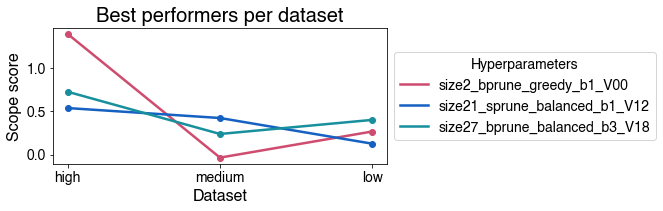

In [12]:
# get the highest scope score for each dataset

# stack the results into a single dataframe
def stacking():
    stacked_results =  pd.DataFrame({key:value.stack() for key,value in dfs_results.items()})
    stacked_results.index = [f"size{midx[0]}_"+midx[1] for midx in stacked_results.index]
    return stacked_results
stacked_results = stacking()
hyperpar_local_bests = []
for dset in datasets:
    # get the highest score
    max_score = stacked_results[dset].max()
    # get the position of this score
    hyperpar = stacked_results[stacked_results[dset] == max_score].index.to_list()[0]
    hyperpar_local_bests.append(str(hyperpar))
    print(f"Best scope score for the dataset '{dset}': {round(max_score,2)} ({hyperpar})")
# Plot the settings that gave the best results for one of the datasets
plt.figure(figsize=(6, 2.5))
plotting_data = stacked_results.transpose()[hyperpar_local_bests]
for j,col in enumerate(plotting_data.columns):
    style = '-' if j <= 6 else '--' if j <= 13 else ':'
    plotting = plotting_data[col][plotting_data[col].notna()]
    plt.plot(plotting.index, plotting.values, label = col, color=all_colors[j], linestyle=style, linewidth=2.5,zorder=1)
    plt.scatter(plotting.index,plotting.values,zorder=2, color=all_colors[j])
plt.title('Best performers per dataset',fontsize=20)
plt.yscale("linear")
plt.xlabel("Dataset")
plt.ylabel("Scope score")
plt.legend(title='Hyperparameters', bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
plt.show()


Get all the Pareto solutions

In [13]:
def pareto_front(df):
    """Get the Pareto front"""
    data = df.to_numpy()
    is_efficient = np.ones(data.shape[0], dtype=bool)
    
    for i, c in enumerate(data):
        if is_efficient[i]:
            # Keep only points that are NOT strictly worse than c
            is_efficient[is_efficient] = np.any(data[is_efficient] > c, axis=1) | np.all(data[is_efficient] == c, axis=1)
            is_efficient[i] = True
    return df[is_efficient].copy()

pareto_settings = pareto_front(stacked_results)
pareto_scaled = pareto_front(stacked_results)
# scale scope scores by normalizing them
for column in pareto_settings.columns:
    min_score = pareto_settings[column].min()
    max_score = pareto_settings[column].max()
    pareto_settings[f"{column} (norm.)"] = (pareto_settings[column] - 0)/(max_score-0)
    pareto_scaled[f"{column} (norm.)"] = (pareto_scaled[column] - min_score)/(max_score-min_score)

# Calculate the standard deviation of the scaled scope scores as a metric for the balance of the Pareto solutions
norm_cols = pareto_settings.columns[pareto_settings.columns.str.contains("norm")]
pareto_settings["Mean norm."] = pareto_settings[norm_cols].mean(axis=1)
pareto_settings["Std.Dev. norm."] = pareto_settings[norm_cols].std(axis=1)
pareto_settings.sort_values(by="Mean norm.",inplace=True,ascending=False)
pareto_scaled = pareto_scaled.reindex(pareto_settings.index)
print(f"There are {len(pareto_settings)} Paretos solutions.")

There are 59 Paretos solutions.


In [14]:
def plot_pareto(pareto_settings,pareto_scaled,rows_to_plot,preferred_solutions, all_colors=all_colors):

    # Plot the pareto solutions
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(2, 2, width_ratios=[2, 2])
    fig.suptitle("Normalized scope scores of Pareto solutions for the different datasets",fontsize=20)
    line_handles = []
    line_labels = []

    # Parallel line plot
    ax1 = fig.add_subplot(gs[0, 0])
    # define a variable for the normalized columns
    norm_cols = ["high (norm.)","medium (norm.)","low (norm.)"]
    for i, (idx, row) in enumerate(pareto_scaled.iterrows()):
        if i == len(all_colors):
            all_colors = all_colors * 2  # make sure that the colors don't run out
        if i in rows_to_plot:
            handle, = ax1.plot(
                norm_cols,
                row[norm_cols],
                marker="o",
                markersize=4,
                color=all_colors[i],
                linewidth=2,
                label=idx)
            line_handles.append(handle)
            line_labels.append(f"{idx}")
    ax1.tick_params(axis='x', labelsize=14) 
    ax1.set_ylim(-0.05, 1.05)
    ax1.set_yscale("linear")
    ax1.set_ylabel("Normalized scope score\n(norm. with min. value = lowest Pareto setting)",fontsize=14)

    # 3D plot
    ax2 = fig.add_subplot(gs[0, 1], projection='3d')

    # plot points
    for i, (_, row) in enumerate(pareto_scaled.iterrows()):
        if i in rows_to_plot and i in preferred_solutions:
            ax2.scatter(row['high (norm.)'], row['medium (norm.)'], row['low (norm.)'], s=80, 
                        color=all_colors[i],edgecolor="k",linewidth=0.5)
        elif i in rows_to_plot:  # smaller points for the less balanced solutions
            ax2.scatter(row['high (norm.)'], row['medium (norm.)'], row['low (norm.)'], s=30, color=all_colors[i])
    
    ax2.set_xlim(-0.05,1.05)
    ax2.set_ylim(-0.05,1.05)
    ax2.set_zlim(-0.05,1.05)

    # add support lines to each plane
    for i, (_, row) in enumerate(pareto_scaled.iterrows()):
        x, y, z = row['high (norm.)'], row['medium (norm.)'], row['low (norm.)']
        col = all_colors[i]
        # ax2.plot([0, x], [y, y], [z, z], color=col, alpha=0.35, linestyle='-', linewidth=2.5)
        # ax2.plot([x, x], [0, y], [z, z], color=col, alpha=0.35, linestyle='-', linewidth=2.5)
        if i in rows_to_plot and i in preferred_solutions:
            ax2.plot([x, x], [y, y], [0, z], color=col, alpha=0.6, linestyle='-', linewidth=3.5)
        elif i in rows_to_plot:
            ax2.plot([x, x], [y, y], [0, z], color=col, alpha=0.35, linestyle='-', linewidth=2)

    ax2.set_xlabel('high',fontsize=14)
    ax2.set_ylabel('medium',fontsize=14)
    ax2.set_zlabel('low',fontsize=14)
    ax2.set_title("Normalized scope score\n(norm. with min. value = lowest Pareto setting)",fontsize=14)


    # Plot mean and standard deviation
    ax3 = fig.add_subplot(gs[1, 0])
    for i, (_, row) in enumerate(pareto_settings.iterrows()):
        if i in rows_to_plot and i in preferred_solutions:
            ax3.scatter(row["Std.Dev. norm."],row["Mean norm."],color=all_colors[i],
                s=80, edgecolor="k",linewidth=0.5)
        elif i in rows_to_plot:  # smaller points for the less balanced solutions
            ax3.scatter(row["Std.Dev. norm."],row["Mean norm."],color=all_colors[i], s=30)
    ax3.set_xlim(pareto_settings["Std.Dev. norm."].min()-0.05,pareto_settings["Std.Dev. norm."].max()+0.05)
    ax3.set_ylim(pareto_settings["Mean norm."].min()-0.05,pareto_settings["Mean norm."].max()+0.05)
    ax3.set_xlabel("Std.Dev. of normalized scope scores",fontsize=16)
    ax3.set_ylabel("Mean of normalized scope scores\n(norm. with min. value = 0)",fontsize=14)

    ax4 = fig.add_subplot(gs[1, 1])
    ax4.axis('off')
    ax4.legend(
        line_handles, line_labels,
        title="Pareto Solutions",
        loc="center",
        handleheight=2,
        labelspacing=1.2,
        ncol=2,
        fontsize=12
    )

    plt.tight_layout()
    plt.show()

def get_pareto_table(preferred_solutions,additionally_considered_solutions,preference_column):
    # color names for the plot labels
    color_names = ["red","blue","green","ocher","purple","red brown", "grey", "dark grey", "brown", 
                   "dark pruple", "dark ocher", "dark green", "dark blue", "dark red", "light grey", 
                   "salmon", "light purple", "light brown", "light green", "light blue", "light red"]*5
    
    # make a copy to display the rounded results for better visibility
    df_display_results = pareto_settings.copy(deep=True)
    df_display_results = df_display_results.applymap(lambda x : round(x,2))
    for i,(idx,row) in enumerate(df_display_results.iterrows()):
        df_display_results.loc[idx,"Plot color"] = color_names[i]
        df_display_results.loc[idx,preference_column] = "No"
        if i in preferred_solutions:
            df_display_results.loc[idx,preference_column] = "Yes"
        if i in additionally_considered_solutions:
            df_display_results.loc[idx,preference_column] = "Yes, but less preferred"
    return df_display_results

Only top 15 solutions shown to avoid excessive overcrowding (full list is below)


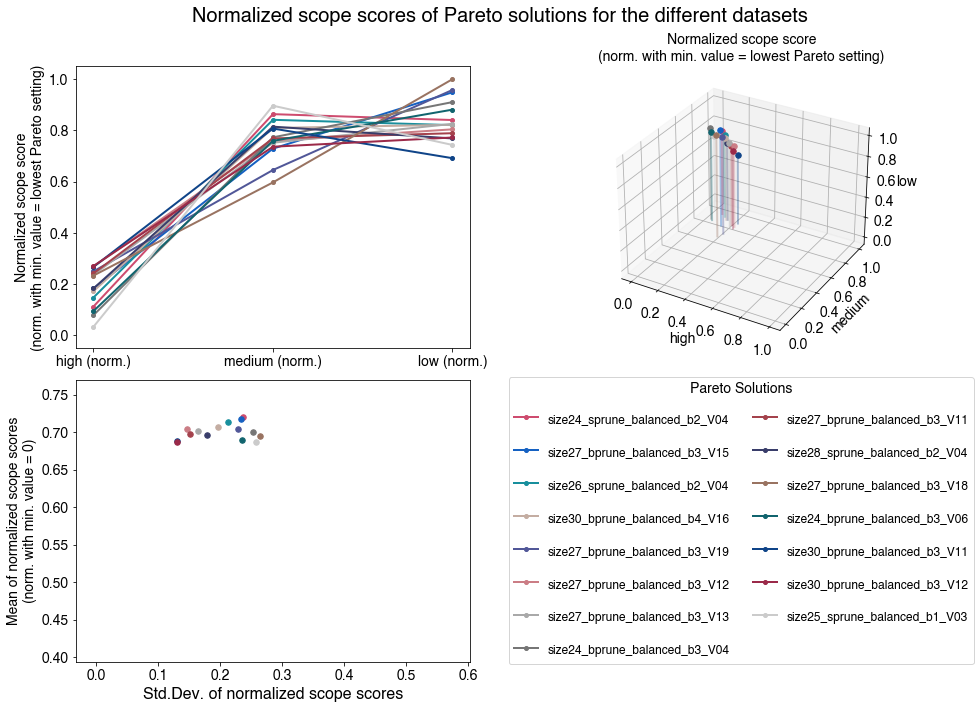

,high,medium,low,high (norm.),medium (norm.),low (norm.),Mean norm.,Std.Dev. norm.,Plot color
size24_sprune_balanced_b2_V04,0.62,0.36,0.35,0.45,0.85,0.86,0.72,0.24,red
size27_bprune_balanced_b3_V15,0.68,0.30,0.38,0.49,0.71,0.96,0.72,0.23,blue
size26_sprune_balanced_b2_V04,0.65,0.35,0.34,0.47,0.83,0.84,0.71,0.21,green
size30_bprune_balanced_b4_V16,0.67,0.34,0.34,0.48,0.79,0.84,0.71,0.20,ocher
size27_bprune_balanced_b3_V19,0.74,0.26,0.39,0.53,0.62,0.96,0.70,0.23,purple
size27_bprune_balanced_b3_V12,0.76,0.31,0.33,0.54,0.74,0.83,0.70,0.15,red brown
size27_bprune_balanced_b3_V13,0.73,0.31,0.34,0.52,0.73,0.85,0.70,0.16,grey
size24_bprune_balanced_b3_V04,0.59,0.32,0.37,0.42,0.75,0.92,0.70,0.25,dark grey
size27_bprune_balanced_b3_V11,0.73,0.32,0.33,0.53,0.75,0.82,0.70,0.15,brown
size28_sprune_balanced_b2_V04,0.68,0.34,0.32,0.49,0.80,0.80,0.70,0.18,dark pruple


In [15]:
preferred_solutions = []
additionally_considered_solutions = []
print("Only top 15 solutions shown to avoid excessive overcrowding (full list is below)")
plot_pareto(pareto_settings,pareto_scaled,list(range(15)),preferred_solutions)
df_display_results = get_pareto_table(preferred_solutions,additionally_considered_solutions,"Further considered")
df_display_results.drop(columns="Further considered")

In [16]:
# get the pareto solution for which fine-tuning can be conducted because they were not in the constrained scope
# and whose mean normalized scope score is close to the best value so far (> 0.6)
col_of_interest= []
for idx in df_display_results.index.to_list():
    scope_size = int(idx.split("_")[0][4:])
    batch_size = int(idx.split("_")[3][1:])
    if ((batch in [1,2]) or (scope_size >= 30)) and pareto_settings.loc[idx,"Mean norm."] > 0.6:
        col_of_interest.append(idx)

df_display_results.loc[col_of_interest].drop(columns="Further considered")


,high,medium,low,high (norm.),medium (norm.),low (norm.),Mean norm.,Std.Dev. norm.,Plot color
size30_bprune_balanced_b4_V16,0.67,0.34,0.34,0.48,0.79,0.84,0.71,0.20,ocher
size30_bprune_balanced_b3_V11,0.76,0.34,0.29,0.54,0.79,0.73,0.69,0.13,dark blue
size30_bprune_balanced_b3_V12,0.76,0.30,0.32,0.54,0.72,0.80,0.69,0.13,dark red
size30_bprune_balanced_b3_V06,0.70,0.34,0.29,0.50,0.81,0.72,0.68,0.16,light green
size30_sprune_balanced_b2_V04,0.76,0.31,0.30,0.54,0.72,0.74,0.67,0.11,red
size30_bprune_balanced_b3_V04,0.68,0.35,0.28,0.49,0.82,0.69,0.66,0.17,green
size30_bprune_balanced_b3_V14,0.77,0.33,0.27,0.55,0.77,0.68,0.66,0.11,ocher
size30_bprune_balanced_b3_V02,0.71,0.36,0.26,0.51,0.84,0.65,0.66,0.17,purple
size30_bprune_balanced_b3_V13,0.76,0.31,0.28,0.55,0.72,0.71,0.66,0.10,dark grey
size30_sprune_balanced_b3_V02,0.74,0.34,0.26,0.53,0.80,0.64,0.66,0.13,brown


In [17]:
# write down lists of all the settings that will be done for finetuning (all with scope size 44)

# batch pruning
combs_bprune = {
    3: {key: 44 for key in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]},
    4: {key: 44 for key in [3,4,6,7,13,14,16,17]}
    }
# sample pruning
combs_sprune = {
    2: {key: 44 for key in [2,4,5]},
    3: {key: 44 for key in [1, 2, 4, 5]}
    }
datasets = ["high","medium","low"]

## Finetuning the best performing settings

In [ ]:
# # run different settings with batch pruning (pruning before every round of experiments)
# datasets = ["high","medium","low"]
# acqfct = ["balanced"]
# for dset in datasets:
#     for acq in acqfct:
#         for batch in combs_bprune.keys():
#             pruning_dict = combs_bprune[batch]
#             for pruning in pruning_dict.keys():
#                 Benchmark().collect_data(
#                     filename_labelled = f"./../0_Data/Datasets/Datasets_Hyperpar_Opt/data-{dset}.csv",  
#                     name_results = f"./Results_Data/Unconstrained_Scope/screen_bprune/tuning/{acq}_{dset}/{pruning_dict[pruning]}{acq}_b{batch}_V{pruning}",  
#                     objectives=['rate'],  
#                     budget = pruning_dict[pruning],
#                     batches= [batch],
#                     Vendi_pruning_fractions = [pruning],
#                     seeds = 20,
#                     acquisition_function_mode= acq,
#                     pruning_metric= "vendi_batch",
#                     init_sampling_method="random",
#                     )

In [ ]:
# # run different settings with sample pruning (pruning before every round of experiments)
# for dset in datasets:
#     for acq in acqfct:
#         for batch in combs_sprune.keys():
#             pruning_dict = combs_sprune[batch]
#             for pruning in pruning_dict.keys():
#                 Benchmark().collect_data(
#                     filename_labelled = f"./../0_Data/Datasets/Datasets_Hyperpar_Opt/data-{dset}.csv",  
#                     name_results = f"./Results_Data/Unconstrained_Scope/screen_sprune/tuning/{acq}_{dset}/{pruning_dict[pruning]}{acq}_b{batch}_V{pruning}",  
#                     objectives=['rate'],  
#                     budget = pruning_dict[pruning],
#                     batches= [batch],
#                     Vendi_pruning_fractions = [pruning],
#                     seeds = 20,
#                     acquisition_function_mode= acq,
#                     pruning_metric= "vendi_sample",
#                     init_sampling_method="random",
#                     )

In [ ]:
# combine the results for the finetuning runs for each dataset

dfs_unconstrained = {}
for dset in datasets:
    dfs = {}
    for pruning_mode in ["sprune","bprune"]:
        if pruning_mode == "sprune":
            combs = combs_sprune
        else:
            combs = combs_bprune
        for acq in ["balanced"]:
            for batch in combs.keys():
                pruning_dict = combs[batch]
                for pruning in pruning_dict.keys():
                    dfs_progress = Benchmark().progress_plot(budget=pruning_dict[pruning],type_results="scope",
                                        name_results=f"./Results_Data/Unconstrained_Scope/screen_{pruning_mode}"\
                                            f"/tuning/{acq}_{dset}/{pruning_dict[pruning]}{acq}_b{batch}_V{pruning}",
                                        bounds=get_bounds(dset),show_plot = False)
                    dfs[f"{pruning_mode}_{acq}_b{batch}_V{pruning}"] = dfs_progress["means"]
    # combine
    dfs_unconstrained[dset] = pd.concat(dfs,axis=1)
    # clean up the column names (currently multi index)
    dfs_unconstrained[dset].columns = [midx[0] for midx in dfs_unconstrained[dset].columns] 
    dfs_unconstrained[dset].columns = [re.sub(r'V(\d)(?!\d)', r'V0\1', col) for col in dfs_unconstrained[dset].columns]

    # sort the columns
    dfs_unconstrained[dset] = dfs_unconstrained[dset][sorted(dfs_unconstrained[dset].columns)]

There are 166 different scopes with 20 random seeds each for every dataset.
The shown results are averaged across the random seeds.


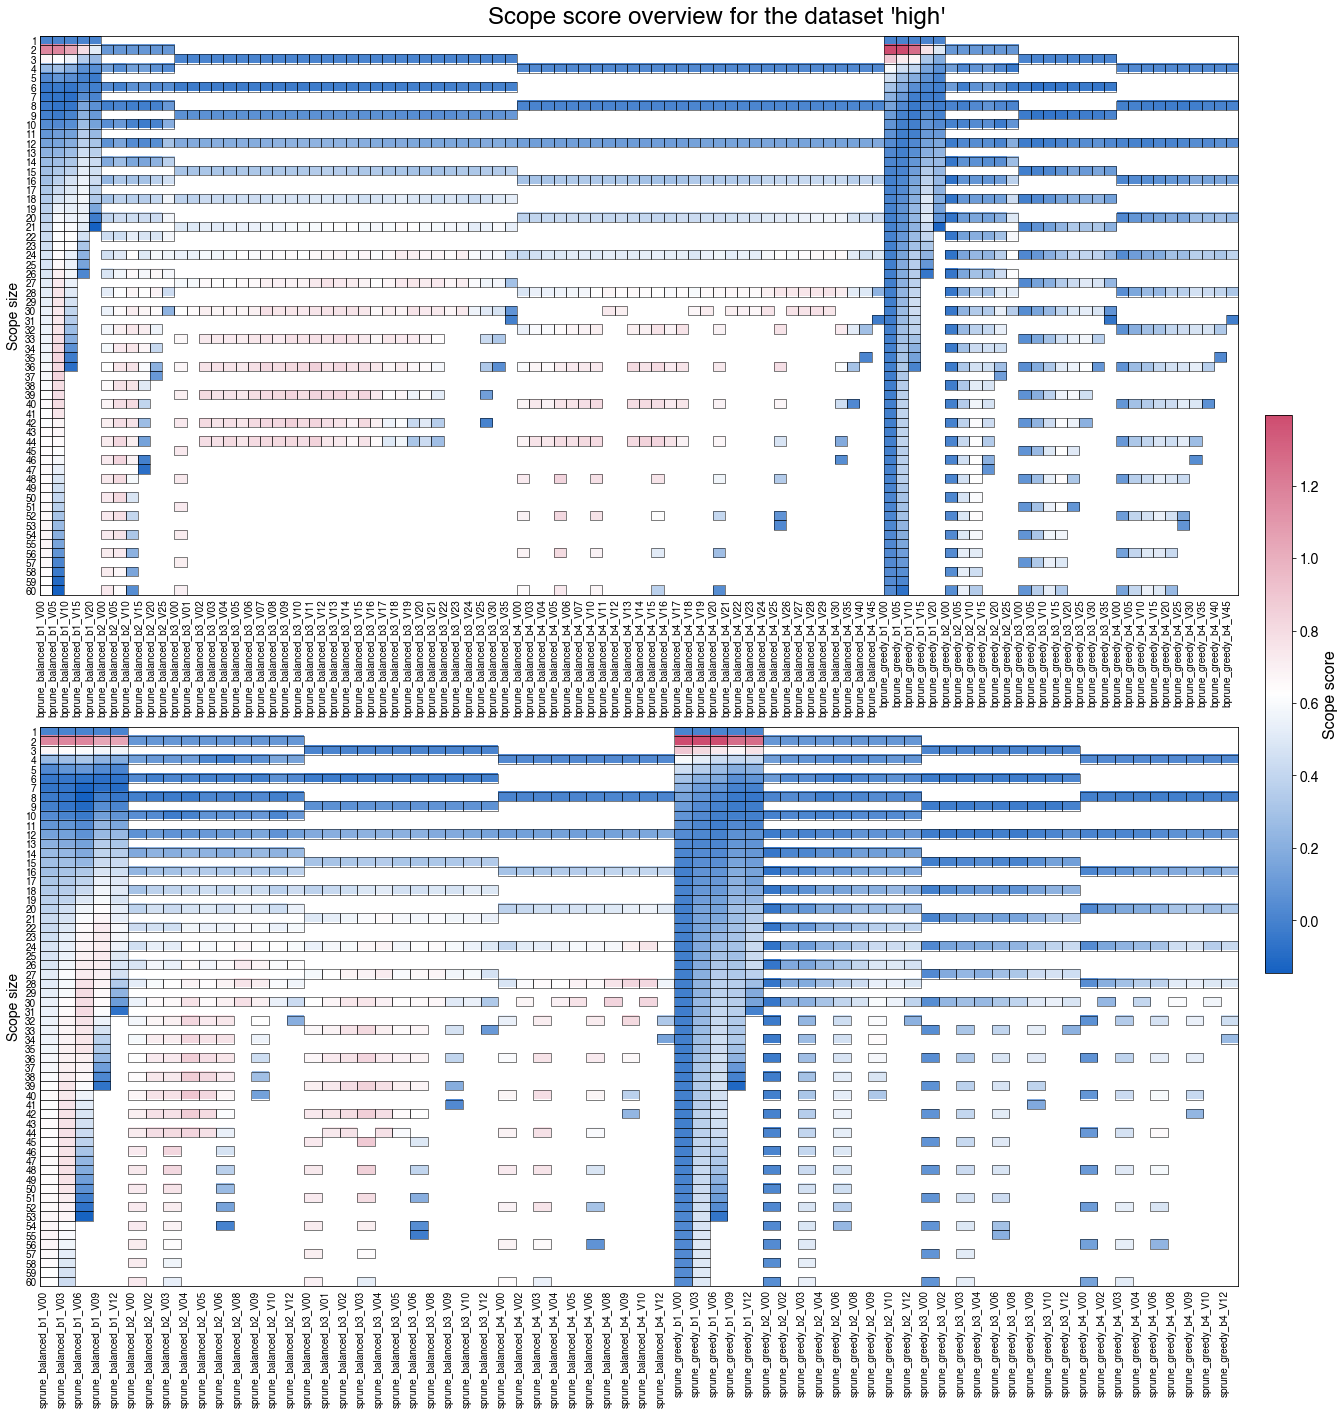

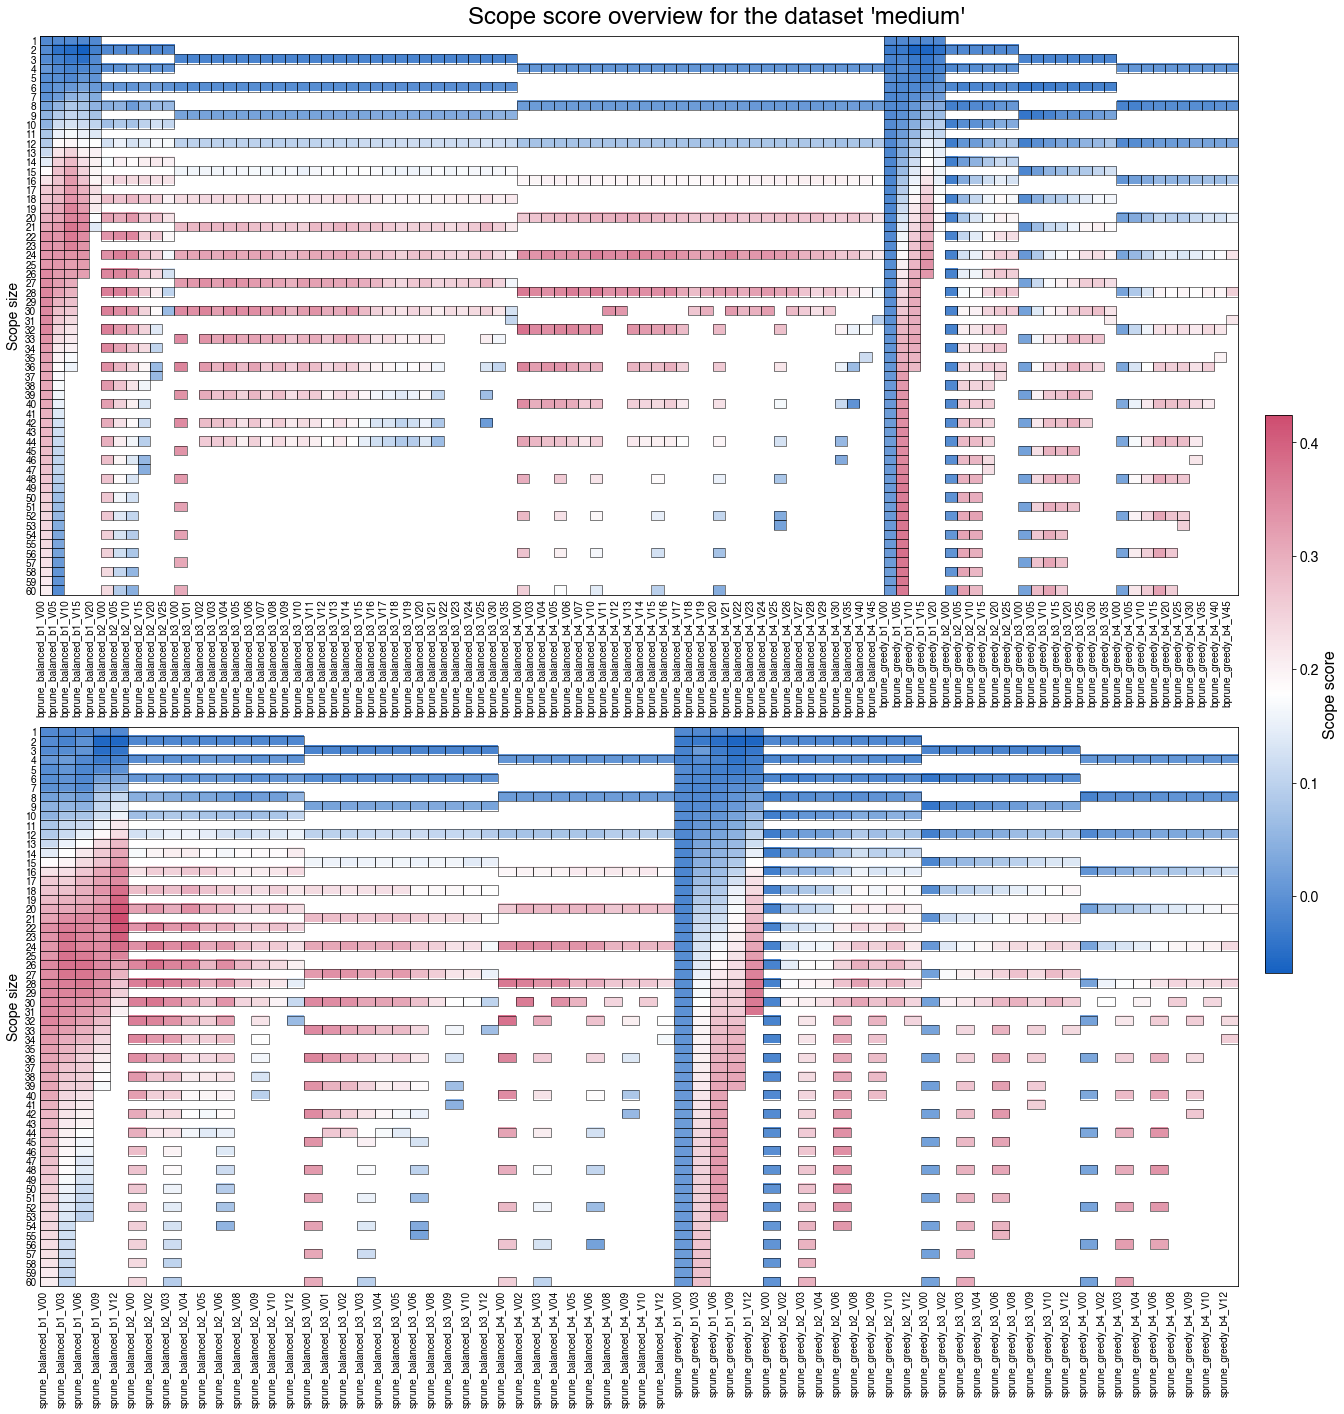

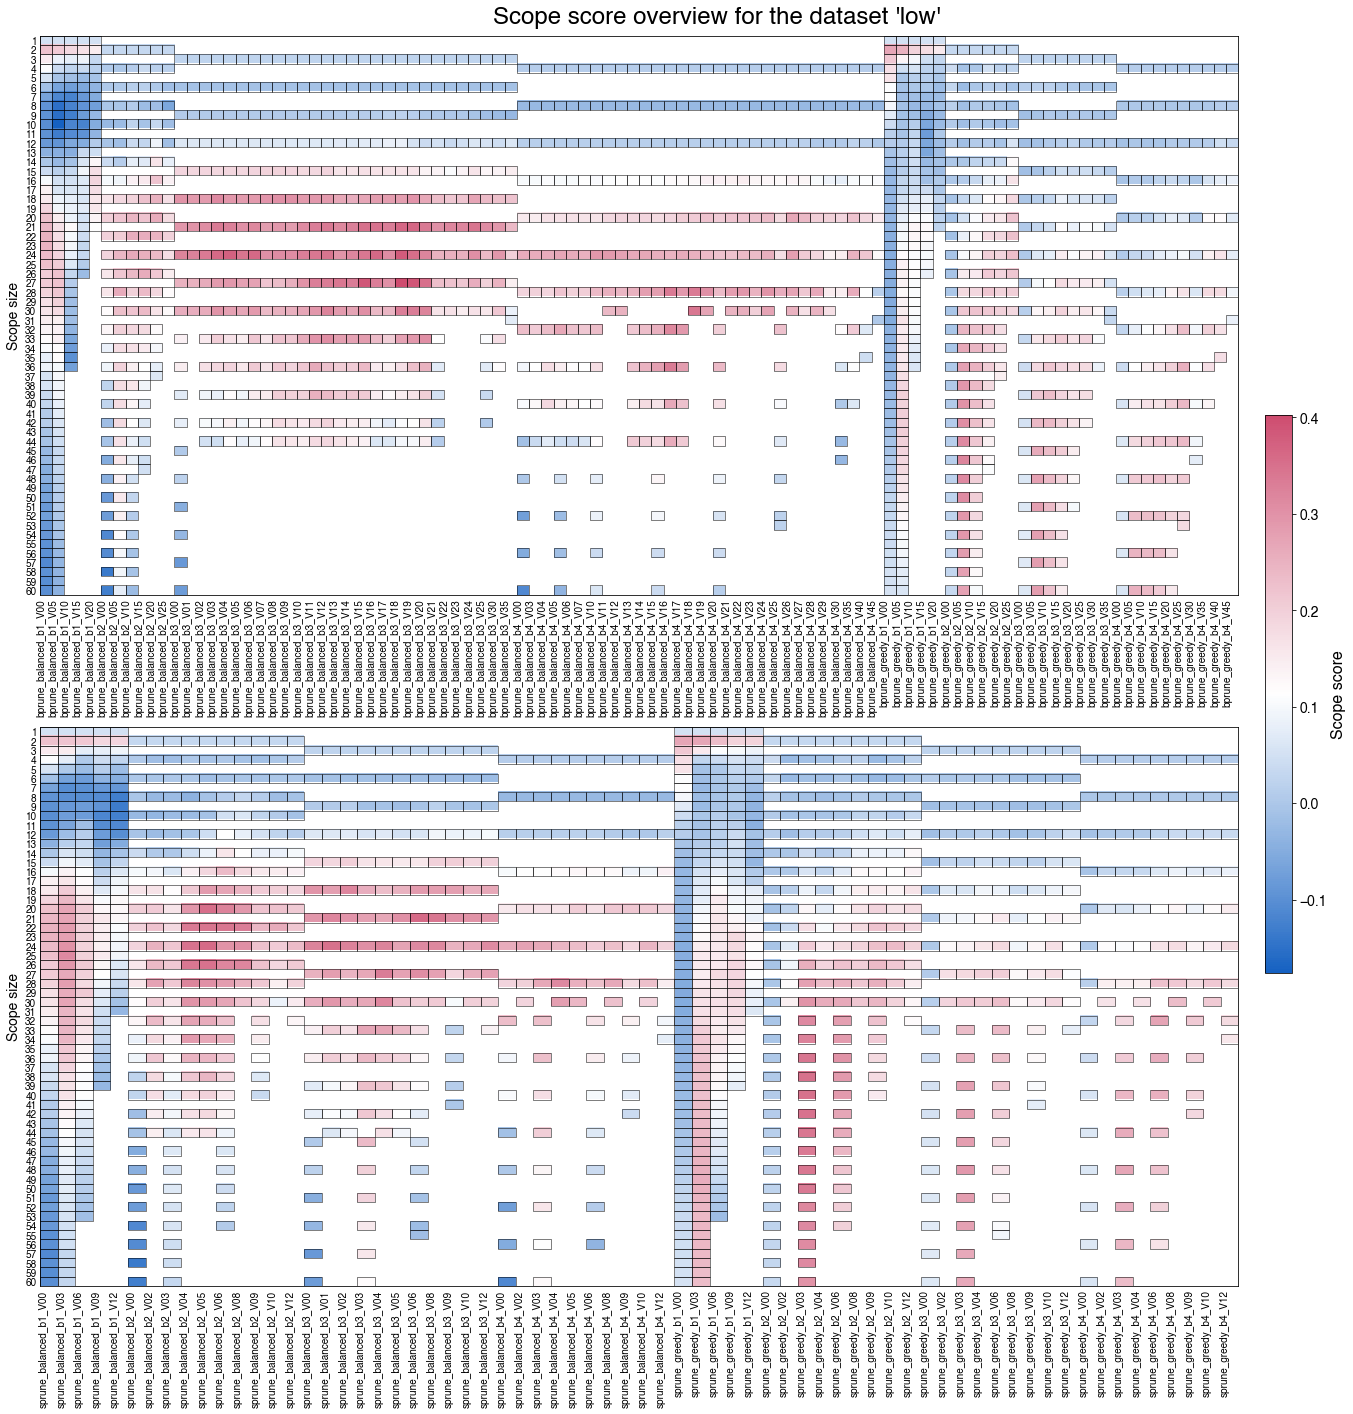

In [21]:
# combine with the already existing results
for dset in datasets:
    # combine
    dfs_results[dset] = pd.concat([dfs_results[dset],dfs_unconstrained[dset]],axis=1)
    # some settings were run again to extend the scope size.
    dfs_results[dset] = dfs_results[dset].loc[:, ~dfs_results[dset].columns.duplicated(keep="last")]

    # sort the columns
    dfs_results[dset] = dfs_results[dset][sorted(set(dfs_results[dset].columns))]    

# plot the overview for all the results
get_overview_plot() 

In [22]:
stacked_results = stacking()
highest_scores = []
for dset in datasets:
    max_val = stacked_results[dset].max()
    highest_scores.append(max_val)
    print(f"Highest scope score for dataset {dset}: {round(max_val,2)}")

pareto_settings = pareto_front(stacked_results)
pareto_scaled = pareto_front(stacked_results)
# scale scope scores by normalizing them
for column in pareto_settings.columns:
    min_score = pareto_settings[column].min()
    max_score = pareto_settings[column].max()
    pareto_settings[f"{column} (norm.)"] = (pareto_settings[column] - 0)/(max_score-0)
    pareto_scaled[f"{column} (norm.)"] = (pareto_scaled[column] - min_score)/(max_score-min_score)

# Calculate the standard deviation of the scaled scope scores as a metric for the balance of the Pareto solutions
norm_cols = pareto_settings.columns[pareto_settings.columns.str.contains("norm")]
pareto_settings["Mean norm."] = pareto_settings[norm_cols].mean(axis=1)
pareto_settings["Std.Dev. norm."] = pareto_settings[norm_cols].std(axis=1)
pareto_settings.sort_values(by="Mean norm.",inplace=True,ascending=False)
pareto_scaled = pareto_scaled.reindex(pareto_settings.index)
print(f"There are {len(pareto_settings)} Paretos solutions.")

Highest scope score for dataset high: 1.4
Highest scope score for dataset medium: 0.42
Highest scope score for dataset low: 0.4
There are 66 Paretos solutions.


Top 15 Pareto solutions. The top overall and the selected constrained settings are highlighted.


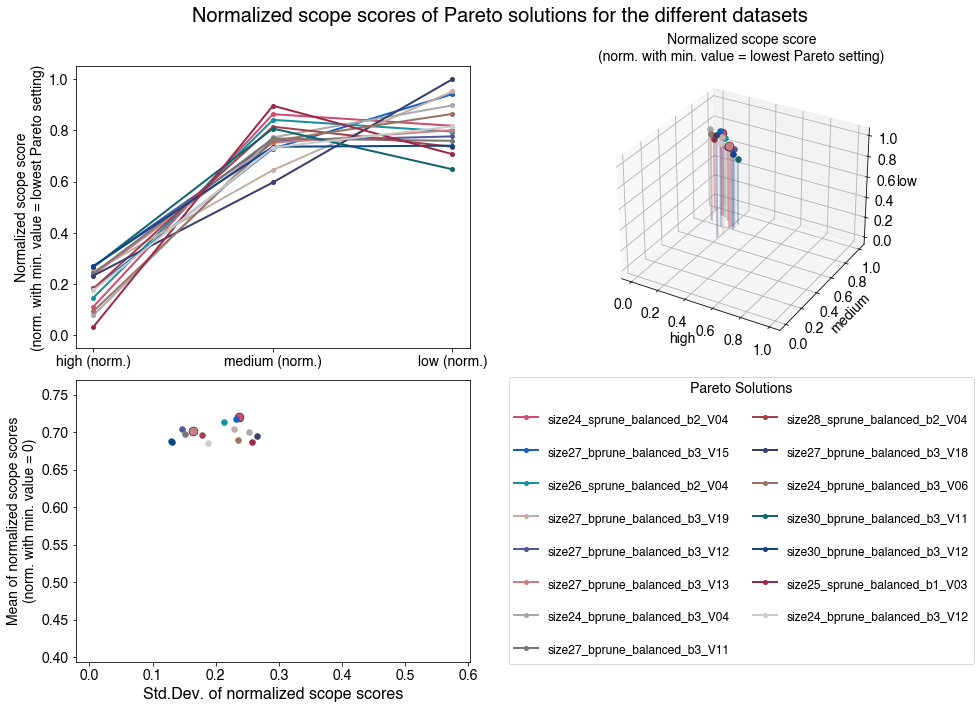

Overview Pareto solutions (sorted by the mean of the normalized scope scores, only top23 shown):


,high,medium,low,high (norm.),medium (norm.),low (norm.),Mean norm.,Std.Dev. norm.,Plot color
size24_sprune_balanced_b2_V04,0.62,0.36,0.35,0.45,0.85,0.86,0.72,0.24,red
size27_bprune_balanced_b3_V15,0.68,0.30,0.38,0.49,0.71,0.96,0.72,0.23,blue
size26_sprune_balanced_b2_V04,0.65,0.35,0.34,0.47,0.83,0.84,0.71,0.21,green
size27_bprune_balanced_b3_V19,0.74,0.26,0.39,0.53,0.62,0.96,0.70,0.23,ocher
size27_bprune_balanced_b3_V12,0.76,0.31,0.33,0.54,0.74,0.83,0.70,0.15,purple
size27_bprune_balanced_b3_V13,0.73,0.31,0.34,0.52,0.73,0.85,0.70,0.16,red brown
size24_bprune_balanced_b3_V04,0.59,0.32,0.37,0.42,0.75,0.92,0.70,0.25,grey
size27_bprune_balanced_b3_V11,0.73,0.32,0.33,0.53,0.75,0.82,0.70,0.15,dark grey
size28_sprune_balanced_b2_V04,0.68,0.34,0.32,0.49,0.80,0.80,0.70,0.18,brown
size27_bprune_balanced_b3_V18,0.73,0.24,0.40,0.52,0.56,1.00,0.70,0.26,dark pruple


In [23]:
# only displaying the top 20 results for visibility
print("Top 15 Pareto solutions. The top overall and the selected constrained settings are highlighted.")
plot_pareto(pareto_settings,pareto_scaled,list(range(15)),[0,5])
df_display_results = get_pareto_table([],[],"Preferred")
print("Overview Pareto solutions (sorted by the mean of the normalized scope scores, only top23 shown):")
df_display_results.drop(columns=["Preferred"]).head(23)

The hyperparameter setting size24_sprune_balanced_b2_V04 provides the highest mean normalized scope score, but the conditions selected in the constrained optimization campaign (max. 30 samples and 10 rounds), size27_bprune_balanced_b3_V13 is performing only slightly worse. Notably, the top 22 settings all have a scope size of 30 samples or less.

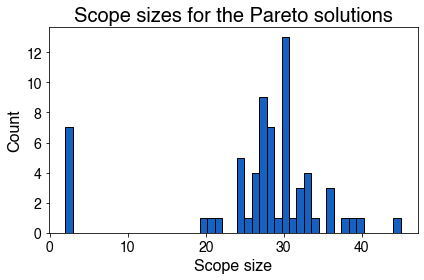

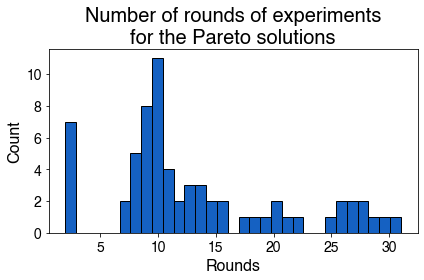

In [24]:
df_exp = df_display_results.copy(deep=True)
df_exp["Scope size"] = [int(idx.split("_")[0][4:]) for idx in df_exp.index]
df_exp["Batch size"] = [int(idx.split("_")[3][1:]) for idx in df_exp.index]
df_exp["Rounds"] = df_exp["Scope size"] // df_exp["Batch size"]
df_exp =df_exp[["Scope size","Batch size","Rounds","Mean norm."]]
plt.figure(figsize=(6, 4))
plt.title("Scope sizes for the Pareto solutions")
plt.hist(df_exp["Scope size"], color=all_colors[1],edgecolor="k",bins = df_exp["Scope size"].max())
plt.xlabel("Scope size")
plt.ylabel("Count")
plt.tick_params(axis='both', which='major')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.title("Number of rounds of experiments\nfor the Pareto solutions")
plt.hist(df_exp["Rounds"], color=all_colors[1],edgecolor="k",bins = df_exp["Rounds"].max())
plt.xlabel("Rounds")
plt.ylabel("Count")
plt.tick_params(axis='both', which='major')
plt.tight_layout()
plt.show()

There some Pareto solutions that only have a scope size of 2 samples. These are likely artefacts of having a low Vendi score and a low average rate so that both values are negative after normalization and their product, the scope score, as a result being high and positive. Regardless of this, as such a scope size is not experimentally relevant, we removed these hyperparameter settings from the list of the Pareto solutions for the subsequent analyses.

In [25]:
# remove the artefacts with scope size = 2
df_exp = df_exp[df_exp["Scope size"] > 2]

def plot_experimental_design(df, round_cutoff=15):
    # Cut off rounds at threshold
    df = df.copy()
    df["Rounds (cut)"] = df["Rounds"].apply(lambda x: round_cutoff if x > round_cutoff else x)

    # Group by (Rounds, Scope size) and count frequency
    grouped = df.groupby(["Rounds (cut)", "Scope size"]).size().reset_index(name='count')
    plt.figure(figsize=(10, 7),dpi=600)
    
    scatter_kwargs = {
        "c": grouped["count"],
        "edgecolors": 'k',
        "s": grouped["count"] * 40,
    }

    if len(df) == 2:
        scatter_kwargs["c"] = all_colors[0]
        scatter_kwargs["s"] = 200
    else:
        scatter_kwargs["cmap"] = "Doyle_cont"

    sc = plt.scatter(grouped["Rounds (cut)"], grouped["Scope size"], **scatter_kwargs, zorder=3)

    cbar = plt.colorbar(sc)
    cbar.set_label("Frequency", rotation=270, labelpad=15)

    # Reference lines
    plt.axvline(x=10, color=all_colors[6], linestyle='--',zorder = 1)
    plt.axhline(y=30, color=all_colors[6], linestyle='--', zorder = 2)

    # Modify x-tick label to reflect cutoff
    xticks = [3*x for x in range(1,int(round_cutoff/3)+1,1)]
    xtick_labels = [f"{int(tick)}+" if tick == round_cutoff else f"{int(tick)}" for tick in xticks]
    plt.xticks(xticks, xtick_labels)

    plt.xlim(0, round_cutoff + 0.5)
    plt.ylim(0, 47)
    plt.xlabel("Rounds of experiments")
    plt.ylabel("Scope size")
    plt.tight_layout()
    plt.show()

Selected conditions from the constrained optimization and the best overall samples form the unconstrained optimization:


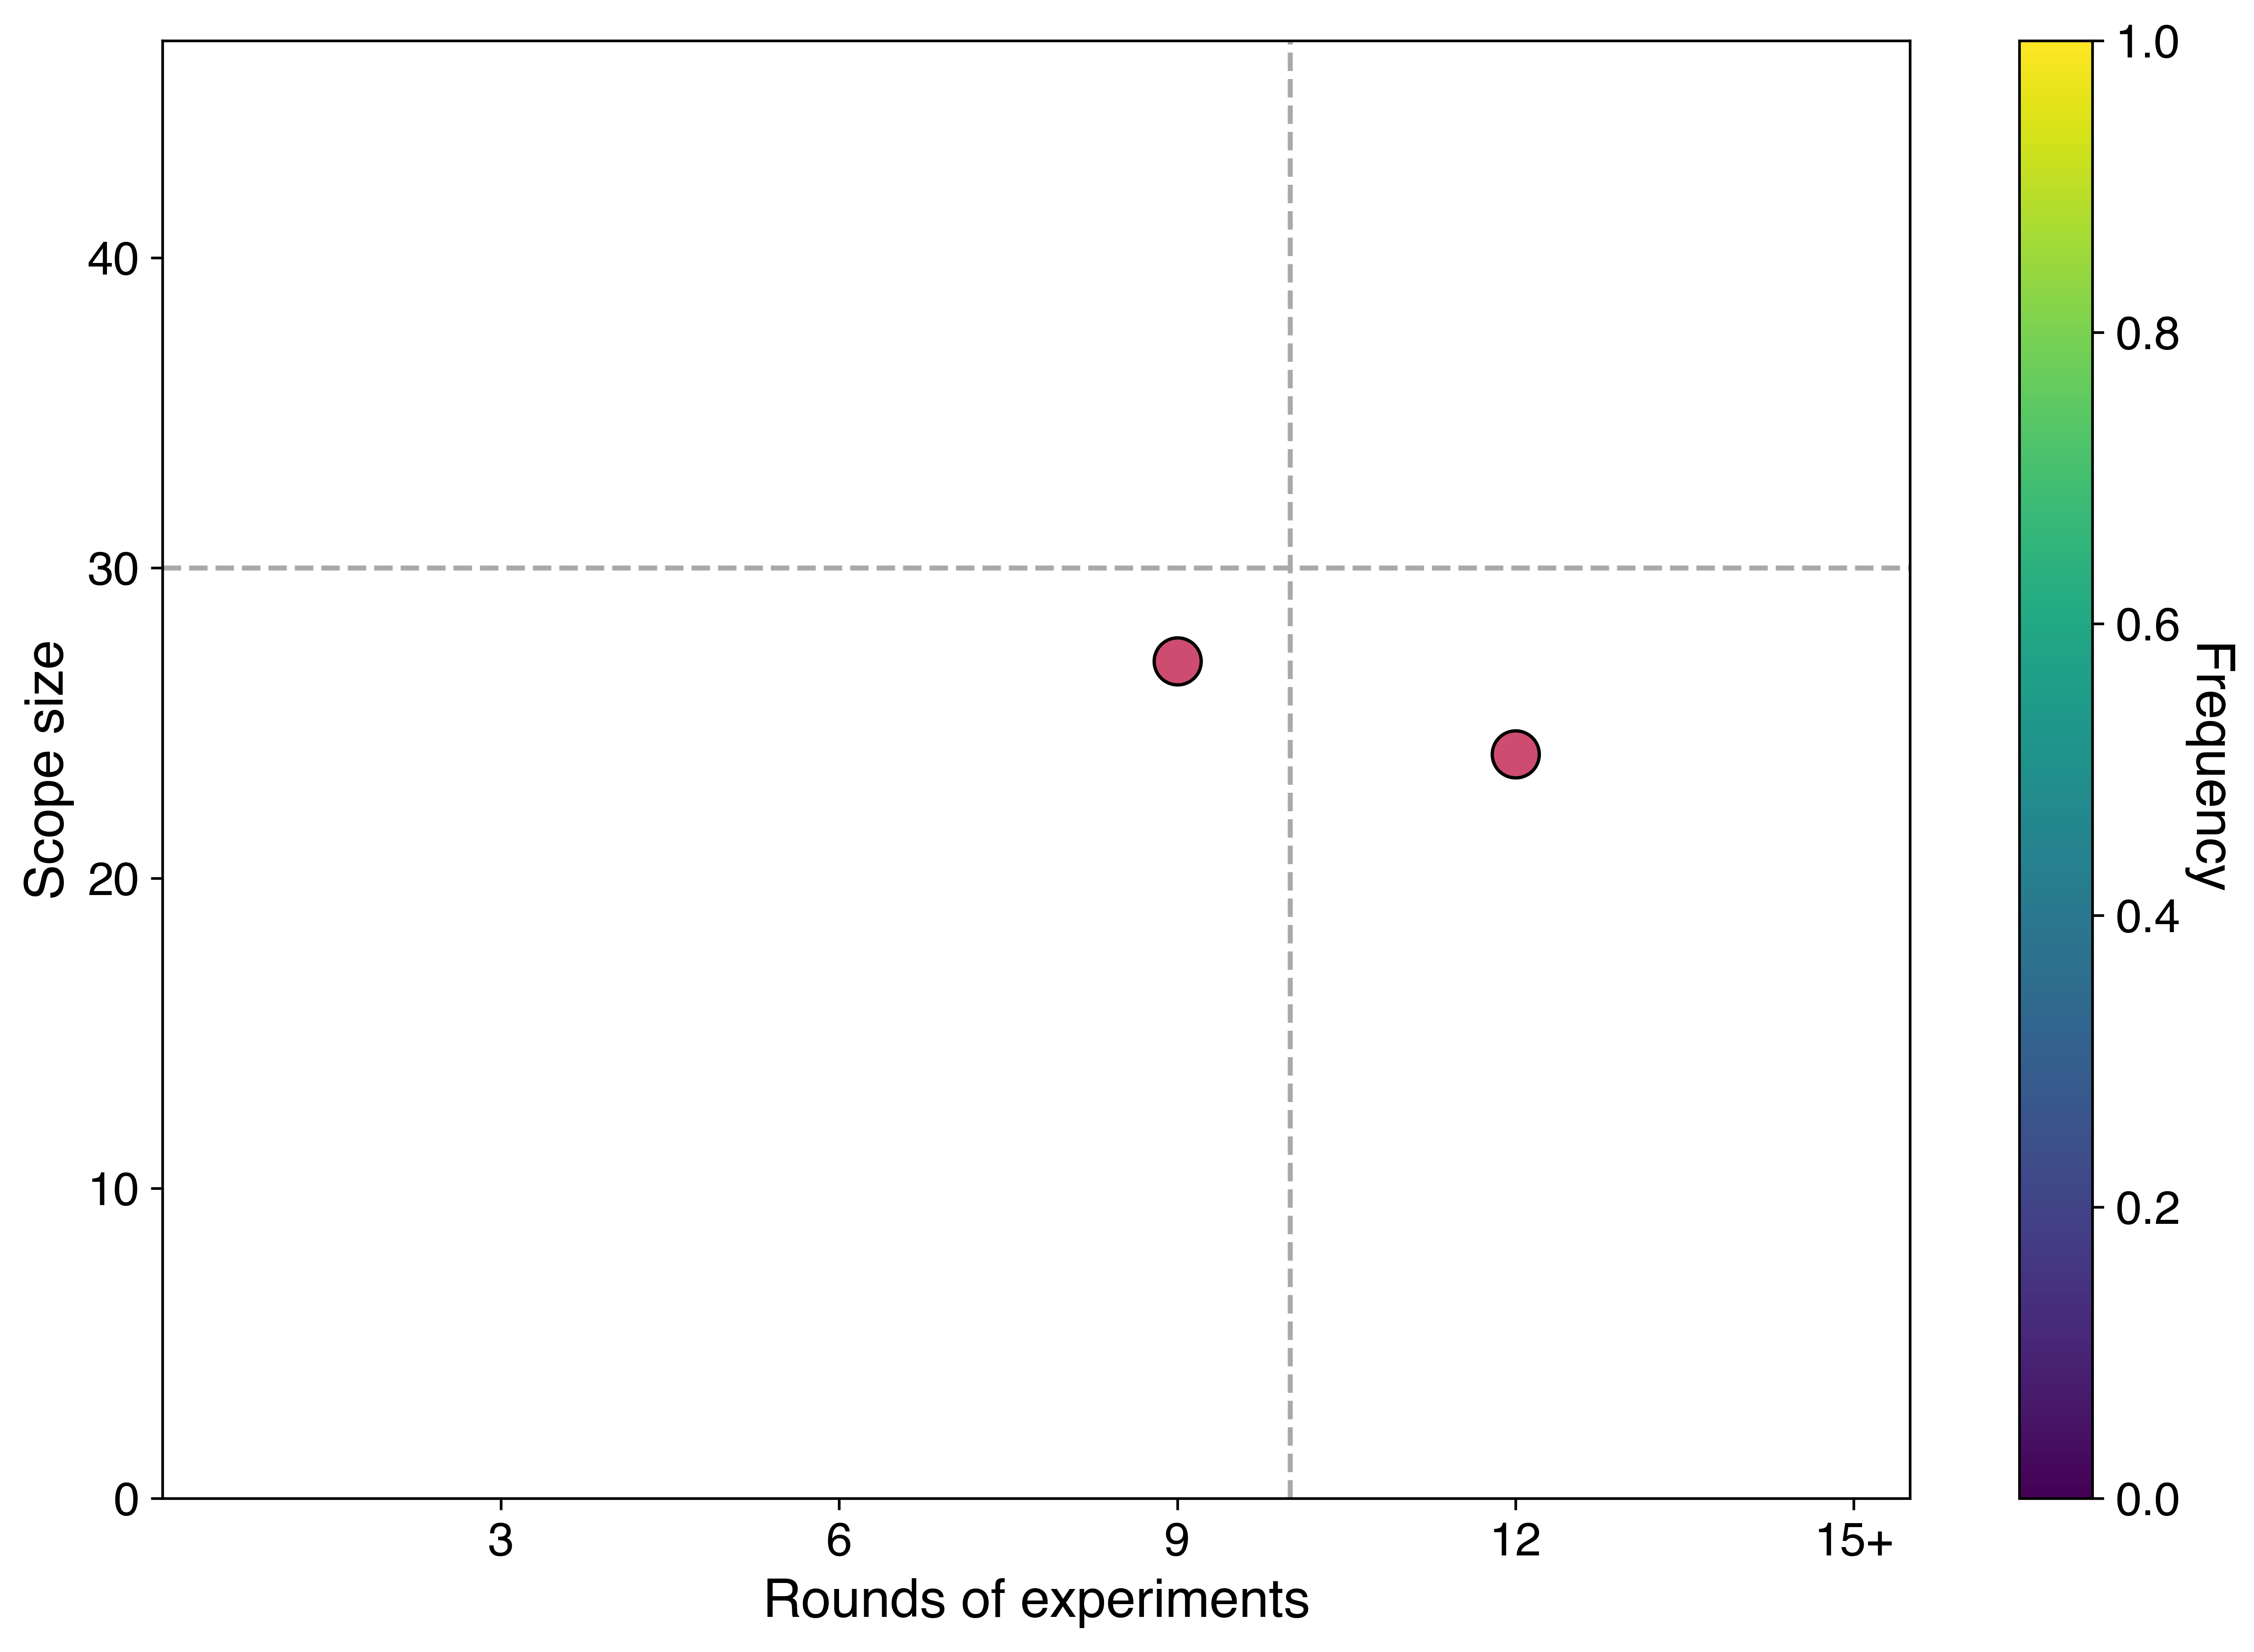

Top22 Pareto solutions


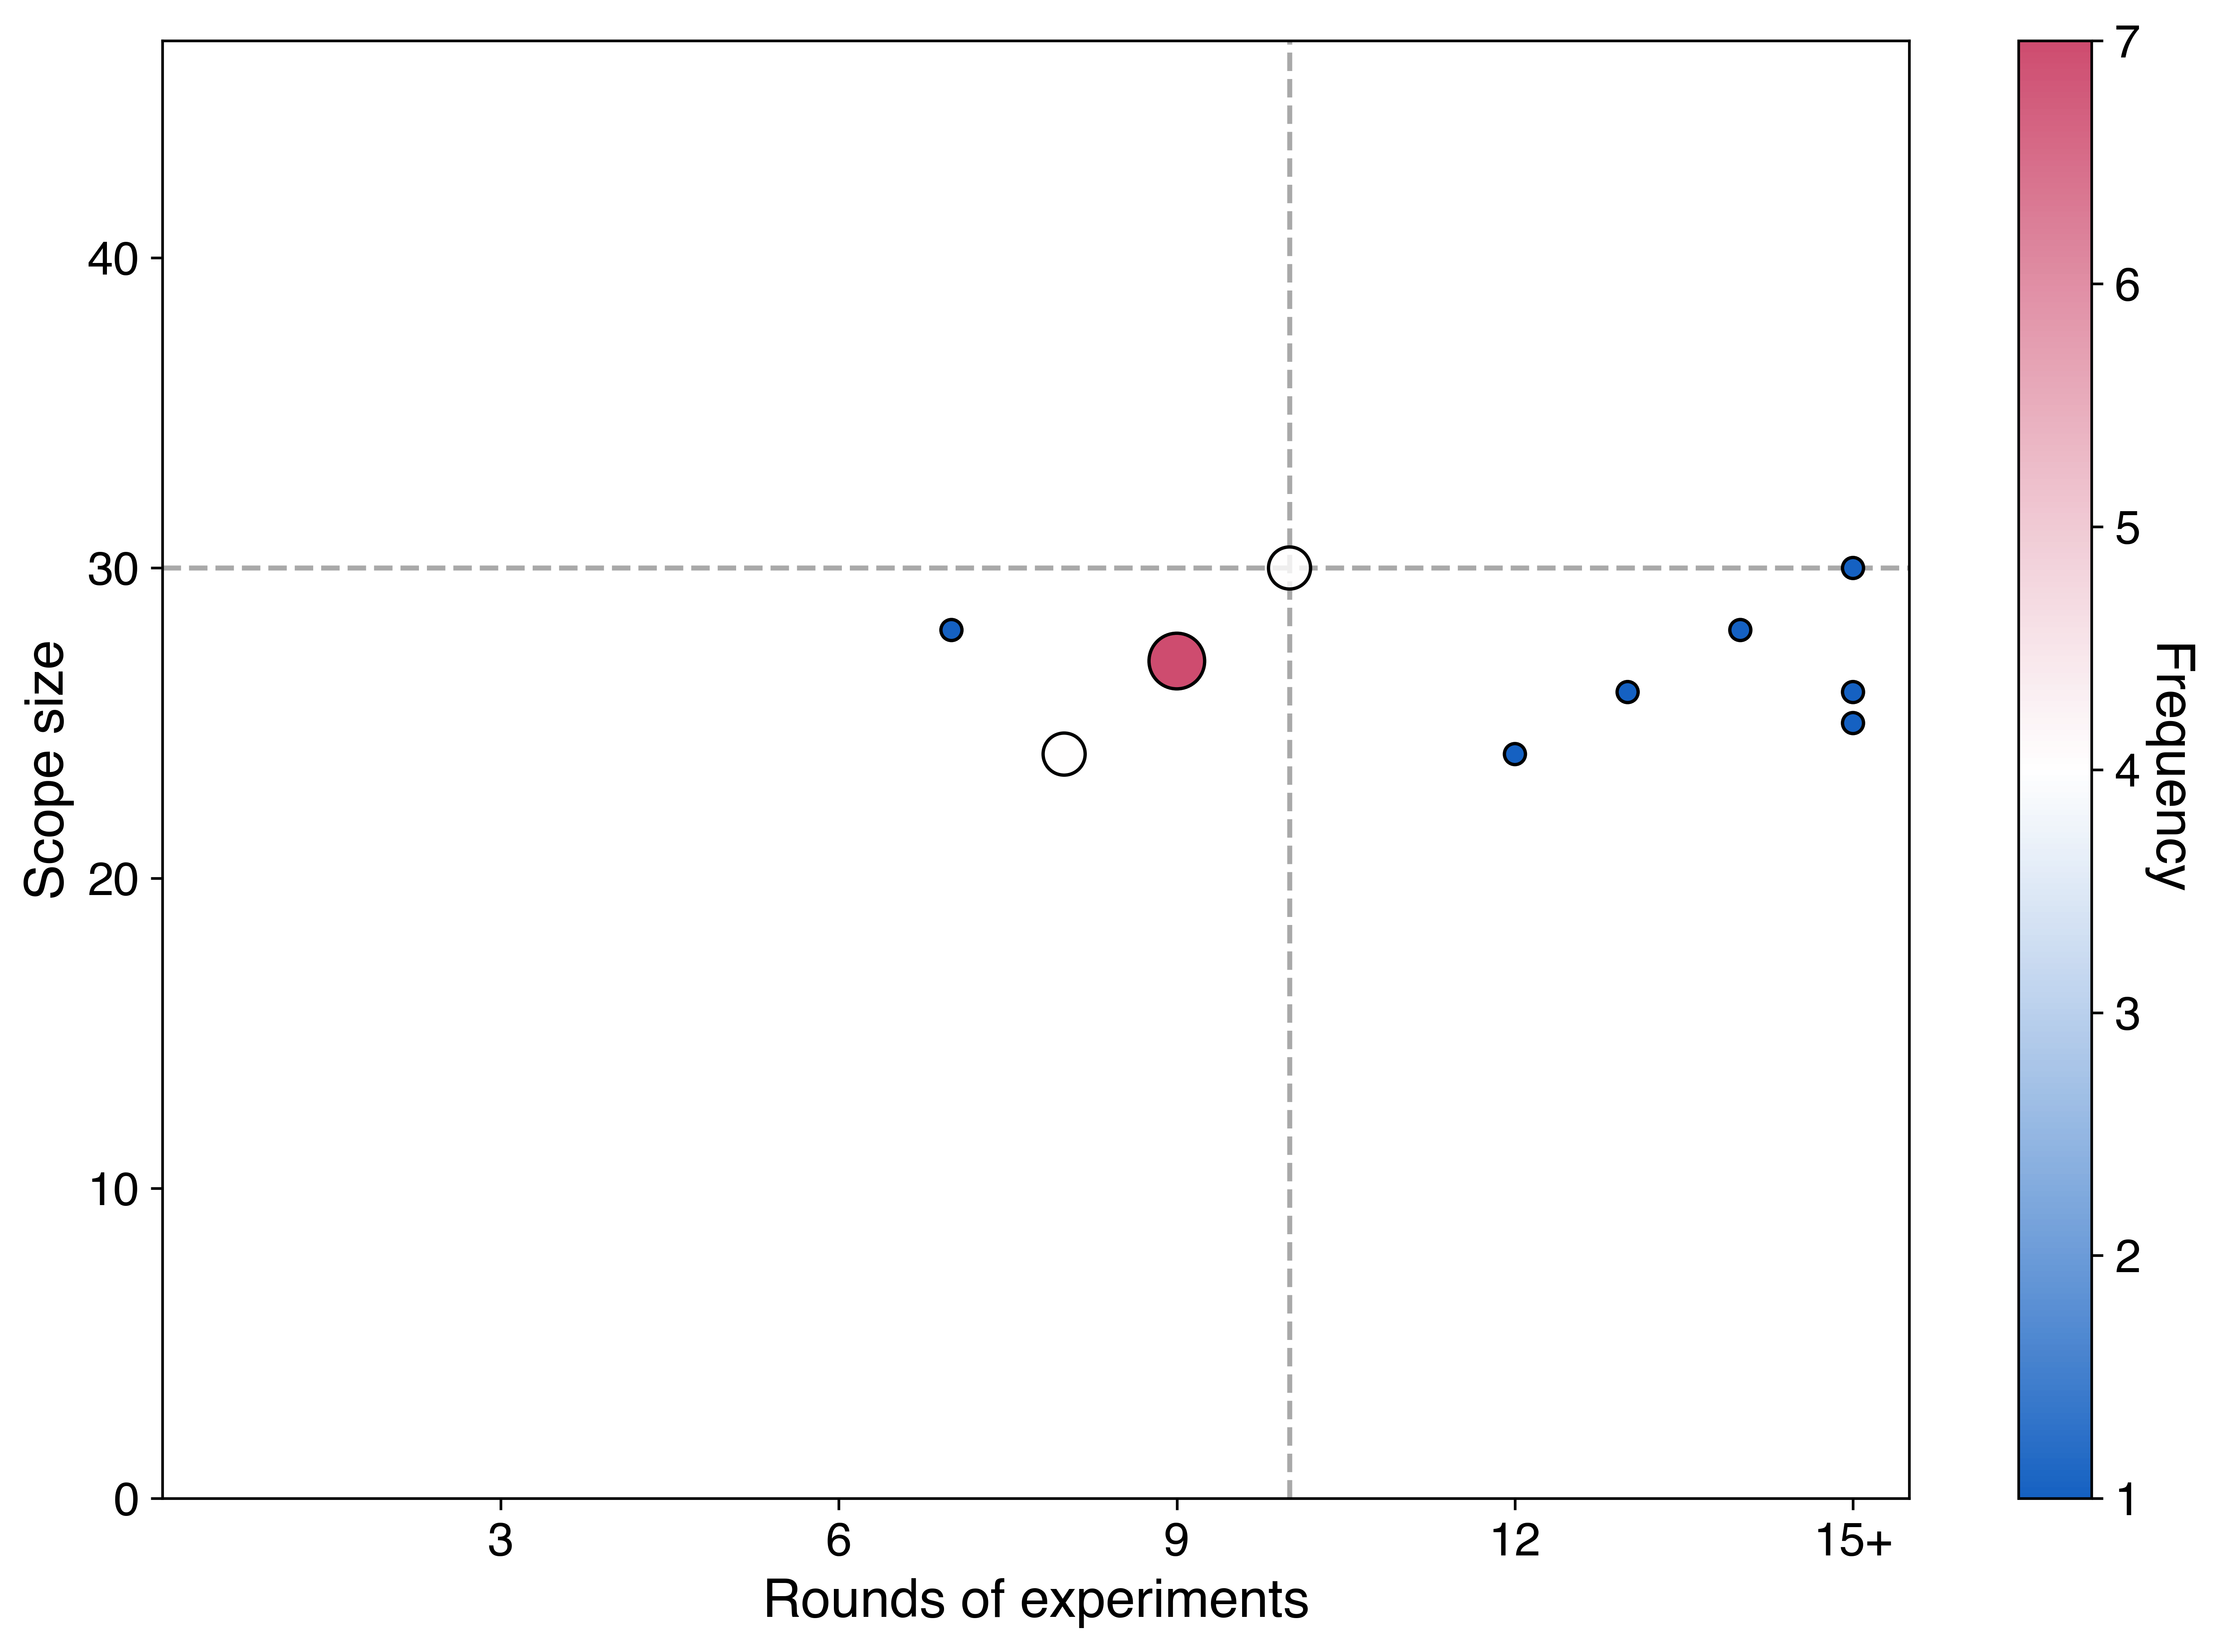

All Pareto solutions (with cutoff)


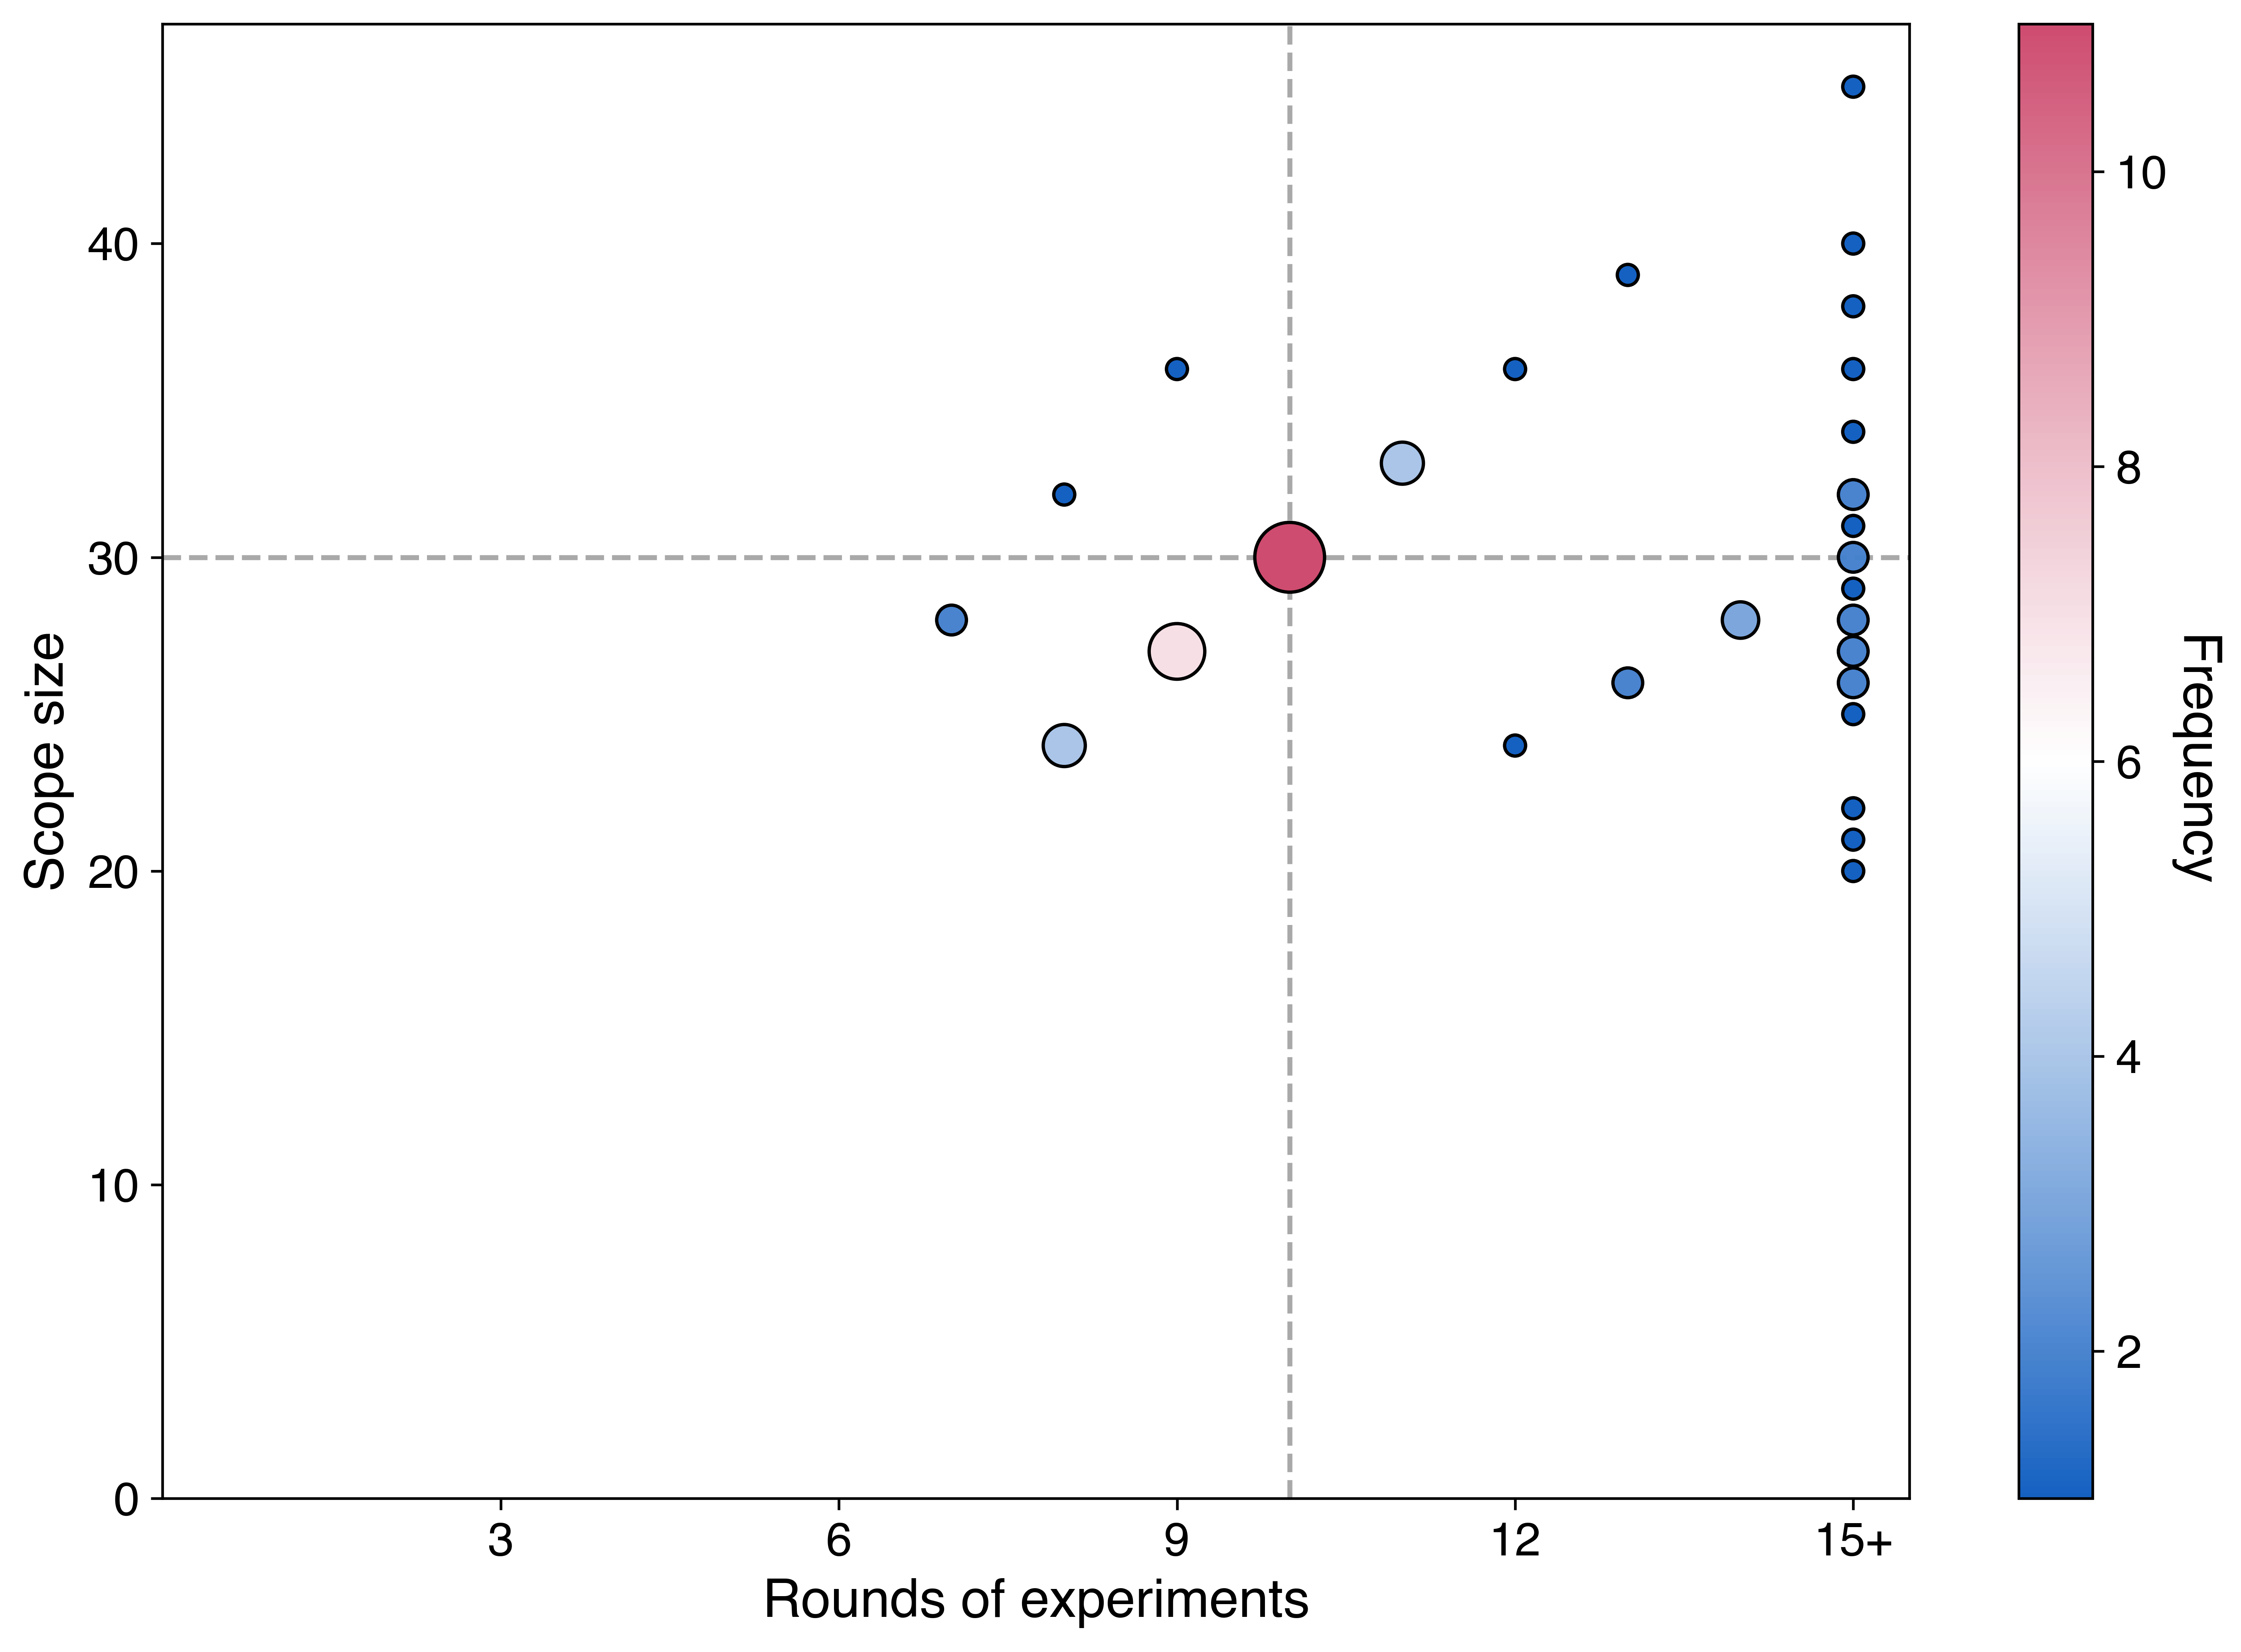

All Pareto solutions (no cutoff)


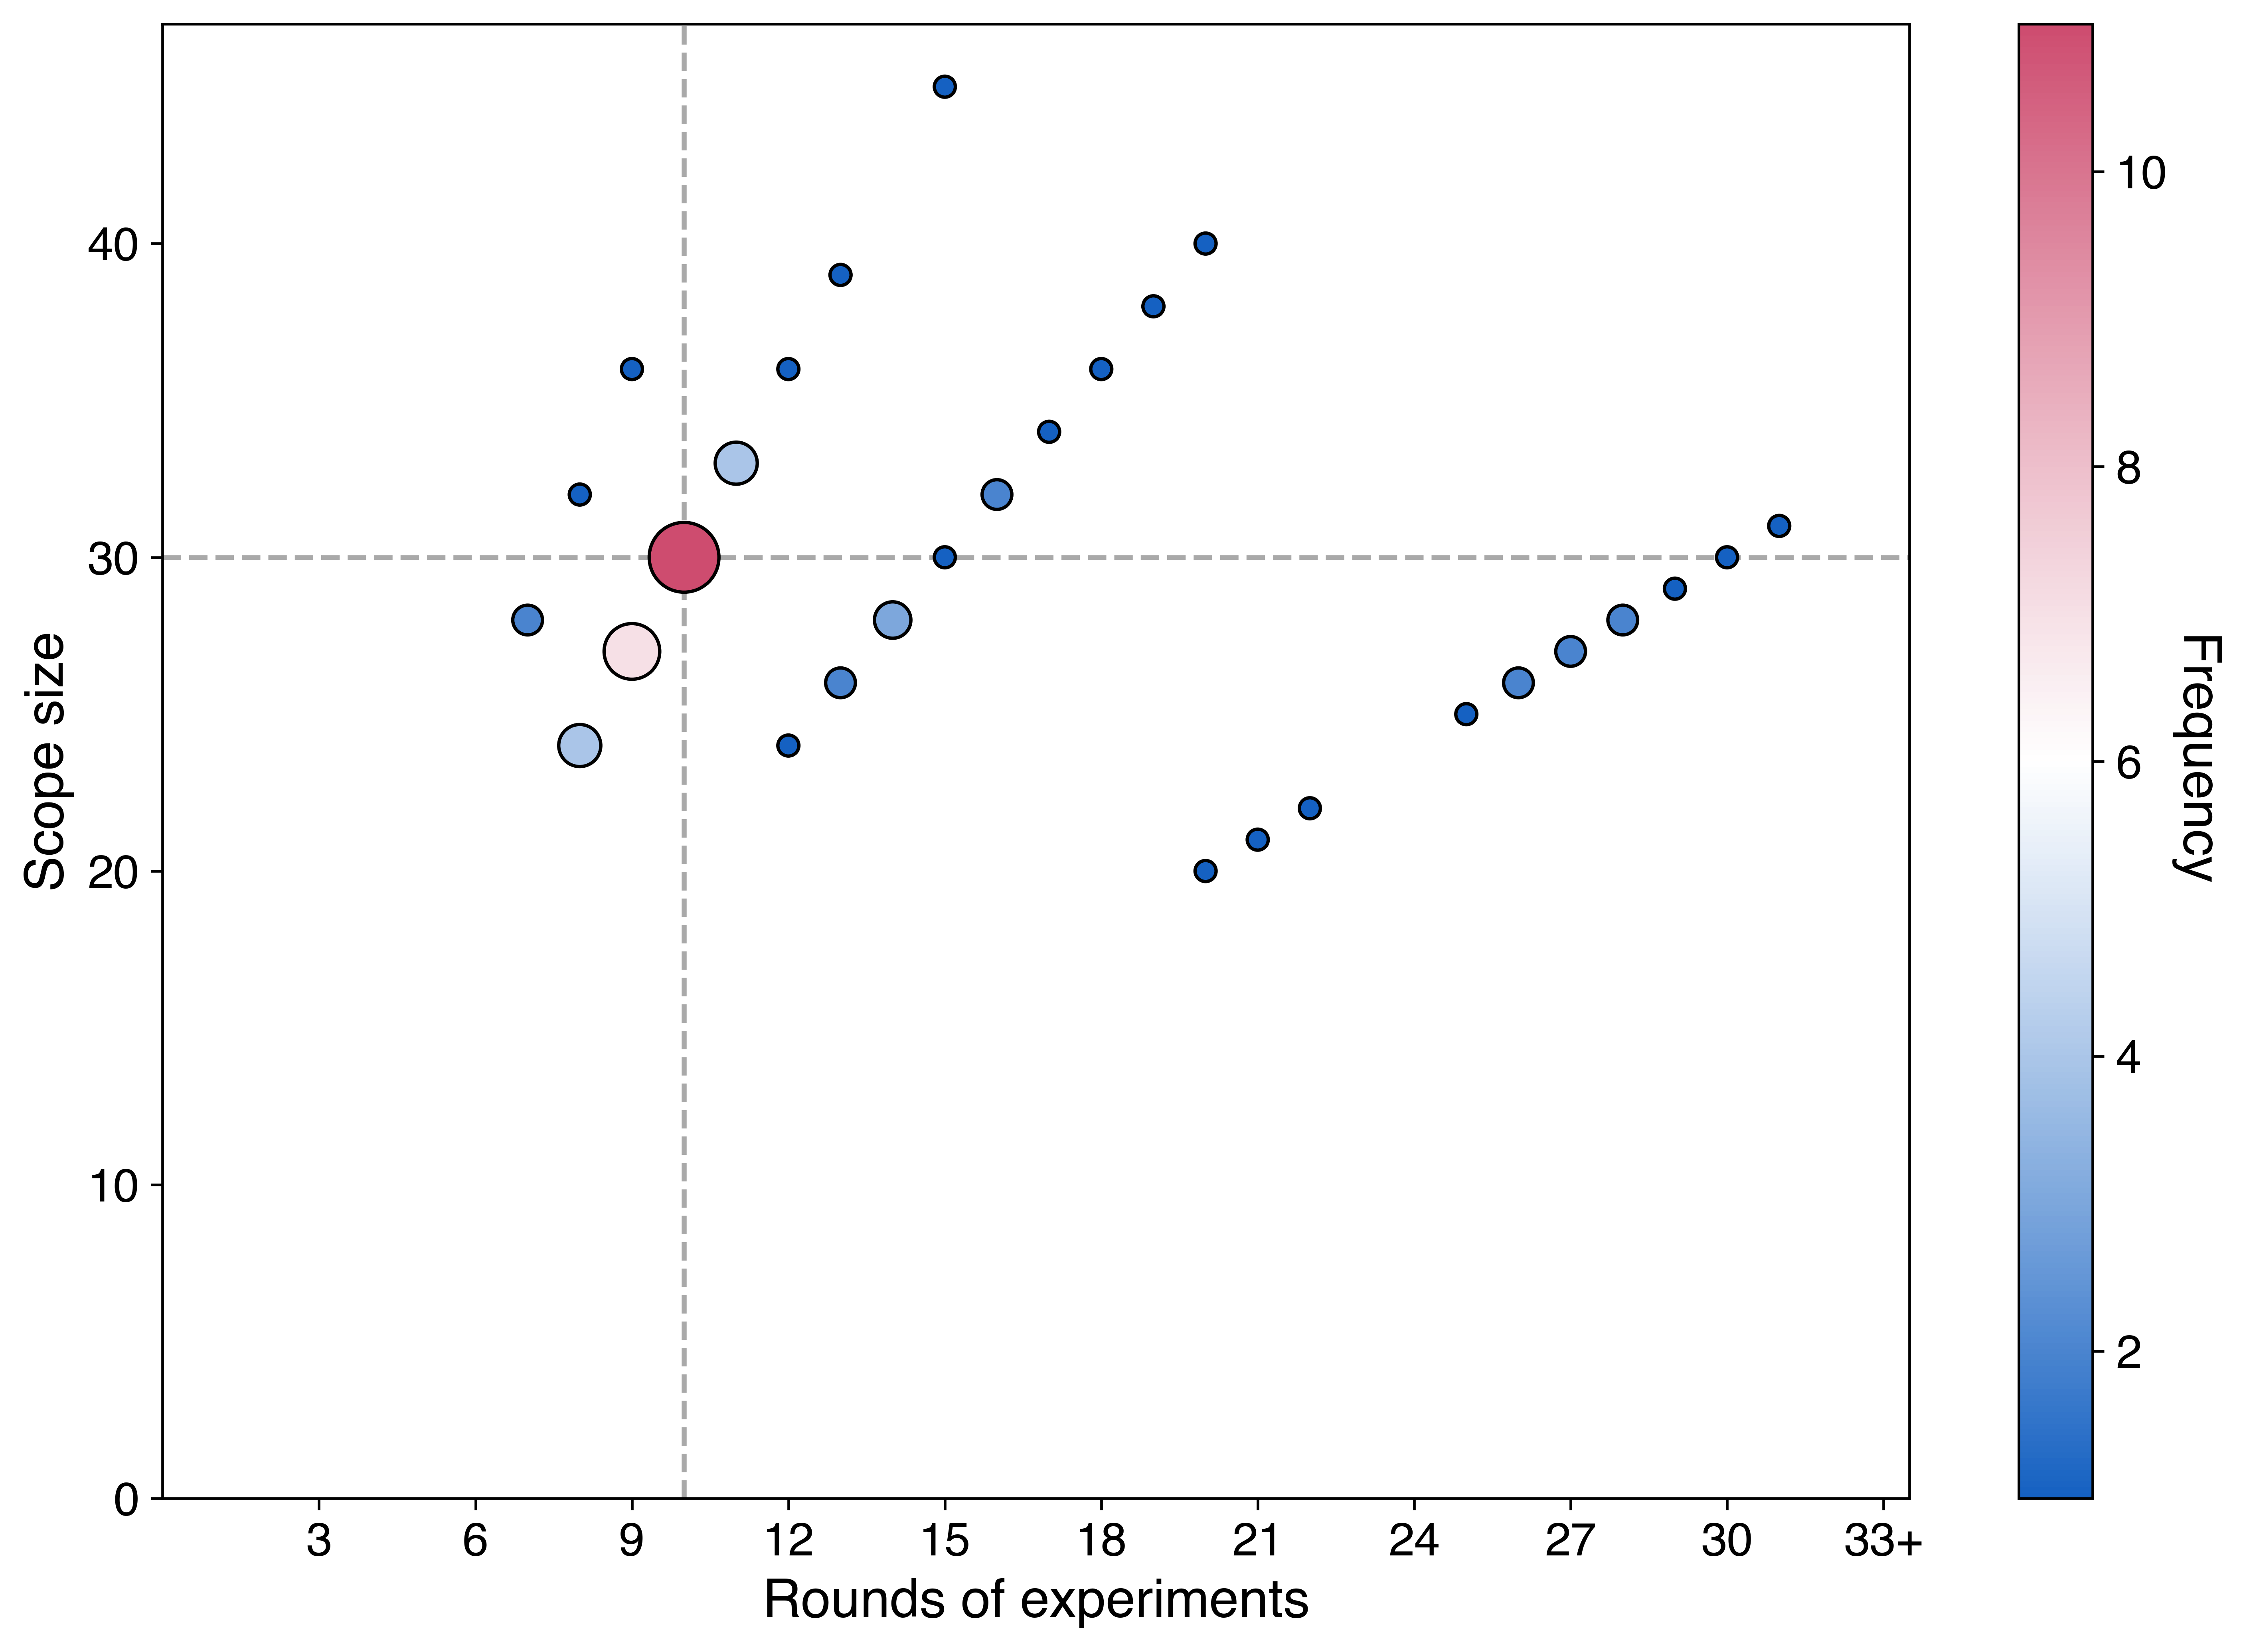

In [27]:
print("Selected conditions from the constrained optimization and the best overall samples"\
      " form the unconstrained optimization:")
plot_experimental_design(df_exp.iloc[[0,5],:], round_cutoff=15)  # 0 is best overall setting; 5 is best contrained setting
print("Top22 Pareto solutions")
plot_experimental_design(df_exp[:22], round_cutoff=15)  # top 22 are all under scope size 30
print("All Pareto solutions (with cutoff)")
plot_experimental_design(df_exp, round_cutoff=15)  # show all
print("All Pareto solutions (no cutoff)")
plot_experimental_design(df_exp, round_cutoff=33)  # show all, no cutoff

Classification of the Pareto solutions by scope size:


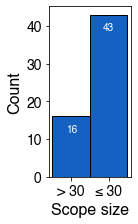

In [28]:
print("Classification of the Pareto solutions by scope size:")
df_exp_class = df_exp.copy(deep=True)
df_exp_class["Class"] = ["> 30" if size > 30 else "≤ 30" for size in df_exp_class["Scope size"]]

counts = df_exp_class["Class"].value_counts().sort_index()

plt.figure(figsize=(2.5*0.8, 4*0.8))
bars = plt.bar(
    counts.index,
    counts.values,
    color=all_colors[1],
    edgecolor='k',
    width=1
)

plt.xlabel("Scope size")
plt.ylabel("Count")
plt.tick_params(axis='both', which='major')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height - 0.05 * max(counts.values),
        f'{int(height)}',
        ha='center', va='top',
        fontsize=10, color='white'
    )

# Adjust layout
plt.tight_layout(pad=1)
plt.show()


Most Pareto solutions, including the top22, are below 30 scope samples.

Classification of the Pareto solutions by rounds of experiments:


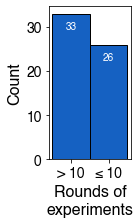

In [29]:
print("Classification of the Pareto solutions by rounds of experiments:")
df_exp_class = df_exp.copy(deep=True)
df_exp_class["Class"] = ["> 10" if size > 10 else "≤ 10" for size in df_exp_class["Rounds"]]

counts = df_exp_class["Class"].value_counts().sort_index()

plt.figure(figsize=(2.5*0.8, 4*0.8))
bars = plt.bar(
    counts.index,
    counts.values,
    color=all_colors[1],
    edgecolor='k',
    width=1
)

plt.xlabel("Rounds of\nexperiments")
plt.ylabel("Count")
plt.tick_params(axis='both', which='major')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height - 0.05 * max(counts.values),
        f'{int(height)}',
        ha='center', va='top',
        fontsize=10, color='white'
    )

# Adjust layout
plt.tight_layout(pad=1)
plt.show()
